# INFORME FINAL DE CARRERA: ANÁLISIS DE FLUJO VEHICULAR EN AUTOPISTAS DE AUSA

**Repositorio**:
GitHub: https://github.com/YaninaMarciano/Proyecto-Final-Ac-mica

## Objetivo

En el proyecto de **aplicaciones actuales** realizamos un análisis de **series de tiempo con modelos univariados y de estacionalidad simple**, para **pago en efectivo en estación Illia**, con **datos del período 2017-2019**. Asimismo, el EDA se condujo con un criterio más cercano a la exhaustividad que a una búsqueda deliberada en función de su utilidad. En este trabajo final nos proponemos superarnos en estos aspectos. Para ello, es necesario partir de mejores preguntas, a saber:

- ¿Ampliar la banda horaria de hora pico consigue el objetivo buscado de alterar la distribución horaria vehicular?
- ¿Se netea diariamente el flujo vehicular en ambos sentidos?, ¿cómo es su evolución?
- ¿Se modificó con los años la participación de los distintos medios de pago en el total de peajes?
- ¿Cambia la tendencia de la serie de tiempo al incorporar años (ampliar la ventana)?
- ¿Qué efecto tiene el costo del combustible en la cantidad demandada de peajes?
- ¿Es conveniente usar modelos que toleran estacionalidad simple para modelar series de tiempo con estacionalidad compleja?

En el desarrollo del informe **utilizaremos más datos que en el proyecto 3**, y repetiremos con ellos el análisis del proyecto anterior (bench, SARIMA, y Prophet). Asimismo, **usaremos modelos multivariados** (SARIMA con EXOG y Random Forest), **y modelos que soporten estacionalidad compleja** (TBATS y Prophet), **con un desarrollo del EDA que esté acorde al objetivo de responder las preguntas de investigación**, las cuáles iremos tratando a lo largo del trabajo.

**Nota**: la pandemia y el ASPO modificaron por completo la dinámica de uso de las autopistas, desde marzo 2020 hasta la fecha. Por ello, cualquier análisis a realizar puede servir para pronosticar valores una vez finalizado aquello (desde marzo 2021, quizás). Cuando eso suceda, debemos tener en cuenta que el único medio de pago habilitado es el Telepase, obligatorio desde septiembre 2020. Por lo tanto, pronosticar pagos en efectivo en el futuro tendría valor para demostrar conocimiento en el uso de los modelos, pero su aplicabilidad sería nula.

Sin embargo, el trabajo tiene el objetivo de poder compararse con lo obtenido en el proyecto 3. Por lo tanto, a pesar de lo expuesto, desde el preprocesamiento sólo trabajaremos con Illia y pago en efectivo. Antes de eso, trabajaremos con todas las estaciones de peajes y medios de pago.

## *Explorando los datasets*

In [1]:
#Importamos librerías de uso común
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
import datetime

In [2]:
#Cargamos los csv files por año y los transformamos en datasets
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
data_2016 = pd.read_csv('flujo-vehicular-2016.csv', sep =',')
data_2015 = pd.read_csv('flujo-vehicular-2015.csv', sep =',')
data_2014 = pd.read_csv('flujo-vehicular-2014.csv', sep =',')

In [3]:
#Creamos un bucle para descubrir si los datasets tienen las mismas columnas
lista_1=[data_2014, data_2015, data_2016, data_2017, data_2018, data_2019]
n=2014

for i in lista_1:
    print('Año ', str(n))
    print(i.columns)
    print(i.head())
    n=n+1

Año  2014
Index(['periodo', 'fecha', 'hora', 'dia', 'estacion', 'tipo_vehiculo',
       'forma_pago', 'cantidad_pasos'],
      dtype='object')
   periodo       fecha  hora        dia estacion tipo_vehiculo  forma_pago  \
0   2014.0  2014-01-01   0.0  Miercoles  Alberdi       Liviano  NO COBRADO   
1   2014.0  2014-01-01   0.0  Miercoles  Alberdi       Liviano    EFECTIVO   
2   2014.0  2014-01-01   0.0  Miercoles  Alberdi       Liviano  NO COBRADO   
3   2014.0  2014-01-01   0.0  Miercoles  Alberdi       Liviano    EFECTIVO   
4   2014.0  2014-01-01   0.0  Miercoles  Alberdi       Liviano      AUPASS   

   cantidad_pasos  
0            26.0  
1             2.0  
2             1.0  
3            64.0  
4            17.0  
Año  2015
Index(['periodo', 'fecha', 'hora', 'dia', 'estacion', 'tipo_vehiculo',
       'forma_pago', 'cantidad_pasos'],
      dtype='object')
   periodo       fecha  hora     dia estacion tipo_vehiculo  forma_pago  \
0     2015  2015-01-01     0  Jueves  Alberdi     

Hay diferencias. Hasta el 2015 inclusive no hubo columna para registrar el sentido de circulación. Asimismo, la columna "hora" en 2014 y 2015 fue reemplazada por "hora_inicio" y "hora_fin". Así como están, no podremos concatenar todos los datasets. El punto aquí es decidir si sacrificamos dos años de datos, o las columnas que no son comunes. Esto depende del objetivo que persiga el trabajo. Aquí optaremos por la solución sencilla: sacrificar los dos primeros años.

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [4]:
#Creamos un bucle para iterar los años
lista_2=[data_2016, data_2017, data_2018, data_2019]
n=2016
variables=['estacion', 'sentido', 'tipo_vehiculo', 'forma_pago']
for i in lista_2:
    print('Año ', str(n))
    for j in variables:
        print(i[j].unique())       
    n=n+1

Año  2016
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Centro' 'Provincia']
['Liviano' 'Pesado']
['NO COBRADO' 'AUPASS' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION' 'MONEDERO']
Año  2017
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Centro' 'Provincia']
['Liviano' 'Pesado']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']
Año  2018
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Centro' 'Provincia']
['Liviano' 'Pesado']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
Año  2019
['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Centro' 'Provincia']
['Liviano' 'Pesado']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']


**Tal como hicimos en el proyecto 3, podemos decir entonces que los años 2016, 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:**

- **periodo**: año del dataset 

- **fecha**: año dia mes

- **hora_inicio** hora de inicio de la cuenta de vehiculos

- **hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

- **dia**: dia de la semana 

- **estacion**: Observamos que 'Dellepiane Centro' (sólo es sentido centro) y 'Dellepiane Liniers' (sólo es sentido Provinca), son unificadas en 2019. Las unificaremos para todo el dataset. Lo mismo para el cambio de nombre de la estación Alberdi (2016, 2017 y 2018) a 'Alberti' (2019), lo cuál asumimos un error en la denominación en los dataset. Dejaremos esta última. También se agrega PDB en 2019.

- **sentido**: Centro o Provincia

- **tipo_vehiculo**: Liviano o Pesado

- **forma_pago**: Hay varias y varian entre los años. Modificaremos 'AUPASS' y 'TARJETA DISCAPACIDAD'

- **cantidad_pasos**: Cantidad de vehiculos

## Acondicionando el dataset preliminar

Vamos a concatenar los años, pasar la fecha a datetime, y unificarla con hora_fin. De esta forma, nos podemos deshacer más adelante de los atributos 'período', 'hora_inicio' y 'hora_fin'.

También unificaremos las estaciones Dellepiane para todo el período, y las formas de pago 'AUPASS' con 'TELEPASE' y 'TARJETA DISCAPACIDAD' con 'T. DISCAPACIDAD'. Finalmente, vamos a crear una variable para registrar el mes.

In [5]:
#Unimos los 4 datasets. Podemos hacerlo asi directamente, ya que tienen las mismas columnas
dataset = pd.concat([data_2016, data_2017, data_2018, data_2019])

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reemplazamos categorias para homogeneizar el dataset
dataset.replace({'AUPASS': 'TELEPASE', 'TARJETA DISCAPACIDAD': 'T. DISCAPACIDAD', 'Dellepiane Centro': 'Dellepiane', 
                 'Dellepiane Liniers': 'Dellepiane', 'Alberdi': 'Alberti'}, inplace=True)

#Vamos a crear el atributo "mes" 
dataset['mes'] = dataset['fecha'].dt.month

#Voy a crear la "Q" de peajes en miles para los gráficos
dataset['Qk_peajes'] = dataset['cantidad_pasos']/1000

dataset.head()

periodo  hora_inicio  hora_fin      dia estacion sentido tipo_vehiculo  \
0     2016            0         1  Viernes  Alberti  Centro       Liviano   
1     2016            0         1  Viernes  Alberti  Centro       Liviano   
2     2016            1         2  Viernes  Alberti  Centro       Liviano   
3     2016            1         2  Viernes  Alberti  Centro       Liviano   
4     2016            1         2  Viernes  Alberti  Centro       Liviano   

   forma_pago  cantidad_pasos               fecha  mes  Qk_peajes  
0  NO COBRADO              32 2016-01-01 01:00:00    1      0.032  
1    TELEPASE               9 2016-01-01 01:00:00    1      0.009  
2  NO COBRADO               1 2016-01-01 02:00:00    1      0.001  
3    EFECTIVO               4 2016-01-01 02:00:00    1      0.004  
4      EXENTO               3 2016-01-01 02:00:00    1      0.003

El dataset contiene 4940149 registros con 11 atributos

# ANÁLISIS EXPLORATORIO DE DATOS

Como hemos mencionado, vamos a perfeccionar el EDA realizado en el **proyecto 3**, incorporando nuevos análisis, y modificando aquellos realizados sobre los tópicos más relevantes. En algún caso, eso significará modificar la forma de presentación de los datos. Omitiremos repetir análisis que no generen valor.

Lo + relevante:
- Total de peajes por estación, desagregado por año y mes
- Flujo vehicular diario
- Flujo vehicular semanal
- Flujo vehicular mensual
- Flujo vehicular desagregado por sentido

Nuevos análisis que intentaremos responder:
- Evolución anual de los medios de pago
- Efecto de la ampliación de la ventana de hora pico en la distribución del flujo vehicular diario

## Flujo vehicular según estación, desagregado por año y mes

Vamos a crear una **tabla pivot** de índice múltiple y doble entrada. Es una buena forma de presentar gran cantidad de datos, aunque resulta un tanto dificil de leer. 

In [6]:
#Creamos tabla pivot multinivel (estación y año), con meses en las columnas, y sumando la "q" de peajes de las intersecciones
pd.pivot_table(dataset,
              index=['estacion', 'periodo'],
              columns=['mes'],
              values=['cantidad_pasos'],
              aggfunc=['sum'])

sum                                      \
                   cantidad_pasos                                       
mes                            1        2        3        4        5    
estacion   periodo                                                      
Alberti    2016            432604   408504   465755   461728   462513   
           2017            452578   407688   494834   462512   481430   
           2018            445522   418815   504417   469760   492169   
           2019            432958   421781   473208   455316   484913   
Avellaneda 2016           3956233  3789499  4196074  4090358  4196020   
           2017           4108488  3579521  4184001  3965605  4210916   
           2018           4132434  3692071  4287842  4070135  4213872   
           2019           3897728  3632040  4150984  3840990  4177058   
Dellepiane 2016           2520693  2346947  2569209  2464030  2562934   
           2017           2559988  2194223  2457335  2365905  2470954   
           2018           2536689  2289973  2646010  2401626  2480183   
           2019           2317399  2170854  2453664  2310369  2503421   
Illia      2016           2464306  2484471  2820726  2739122  2811683   
           2017           2639365  2364688  2734740  2629246  2756833   
           2018           2639969  2551479  3075393  2908388  3037557   
           2019           2600777  2607024  3026728  2725833  2986778   
PDB        2019            156131   174665   184411   220518   242718   
Retiro     2016            231422   216596   235487   221731   229198   
           2017            220065   191357   225026   204720   222263   
           2018            164727   133231   136512   123758   116044   
           2019            103411    96422   101469    94949   102154   
Salguero   2016             18455    19005    25424    27950    22017   
           2017             27033    26565    48740    51808    53098   
           2018             53664    51414    63331    67150    75224   
           2019             86194    90602   101671    99657   102773   
Sarmiento  2016             64604    73751    86369    90963    90617   
           2017             51781    61557    92368    85145    83735   
           2018             65016    69017    95541    94850   103704   
           2019             86464    86281   104207   104746   111494   

                                                                          \
                                                                           
mes                      6        7        8        9        10       11   
estacion   periodo                                                         
Alberti    2016      450649   470964   491596   487083   493260   500918   
           2017      481048   486171   499733   492409   514886   518146   
           2018      469602   476224   502359   471069   506904   474886   
           2019      449102   478140   487621   464760   489512   500957   
Avellaneda 2016     4020088  4199575  4334943  4312459  4435749  4448182   
           2017     4152660  4237626  4407130  4381855  4522056  4541063   
           2018     3996327  4115190  4292610  4017753  4380598  4152751   
           2019     3767297  4148925  4175279  4000814  4180398  4167502   
Dellepiane 2016     2482491  2569803  2693338  2689497  2763302  2773069   
           2017     2477117  2541312  2653657  2630440  2788825  2777885   
           2018     2364440  2433471  2530546  2423078  2625443  2468553   
           2019     2326469  2534972  2564610  2501368  2424441  2579686   
Illia      2016     2721771  2806824  2996751  2979349  3053273  3039081   
           2017     2726986  2827076  2921152  2935394  3089570  3084645   
           2018     2825621  2928270  3072788  2849384  2990326  2829937   
           2019     2691338  2936927  2990406  2875084  2951778  2983892   
PDB        2019      589985   633702   597140   723100   695263   716164   
Retiro     2016      219

## Medios de pago: evolución anual (gráfico). Autopistas AUSA

Queremos ver la evolución de los medios de pago para la ventana de cuatro años.

Text(0, 0.5, 'Q peajes (en miles)')

<Figure size 864x432 with 0 Axes>

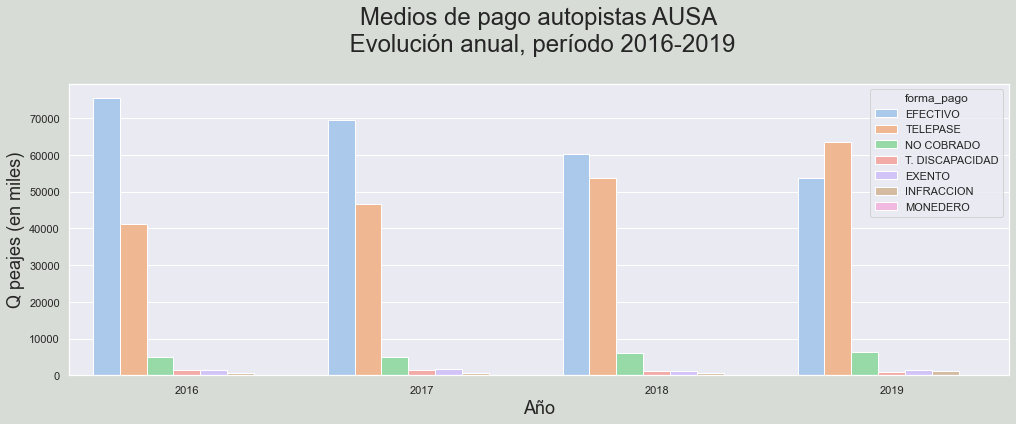

In [7]:
#Realizamos un barplot a partir de un groupby
plt.figure(figsize=(12,6))
ax= dataset.groupby(['periodo', 'forma_pago'])['Qk_peajes'].sum().reset_index()
plt.figure(figsize = (15,5), facecolor='#d8dcd6')
ax = sns.barplot(x='periodo', y='Qk_peajes', hue='forma_pago', data=ax, 
            hue_order=['EFECTIVO', 'TELEPASE', 'NO COBRADO', 'T. DISCAPACIDAD', 'EXENTO', 'INFRACCION', 'MONEDERO'],
           palette='pastel')
plt.title('Medios de pago autopistas AUSA\n Evolución anual, período 2016-2019\n', fontsize=24)
plt.xlabel('Año', fontsize=18)
plt.ylabel('Q peajes (en miles)', fontsize=18)

Vemos que la **dinámica contrapuesta para efectivo (caída contínua) y telepase (crecimiento contínuo)**, observada en el período 2017-2019, se hace extensiva al año 2016. La participación del resto de medios de pago (con o sin erogación), es marginal.

## Flujo vehicular diario (días laborables). Autopistas AUSA

¿Cómo se distribuye el flujo vehicular a lo largo del día laboral?, ¿hay picos en horarios que podríamos considerar de "ida y regreso del trabajo"?, ¿qué diferencia se registra en volúmen de tránsito entre las horas de menor y mayor congestión?

Text(0, 0.5, 'Q peajes')

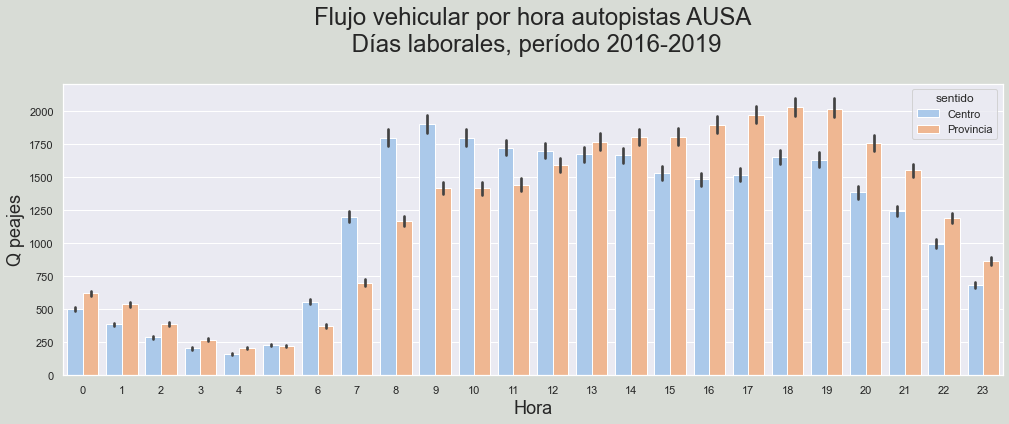

In [8]:
weekday_fv= dataset.groupby(['hora_fin', 'sentido']).resample('H','B', on='fecha')['cantidad_pasos'].sum().reset_index()
plt.figure(figsize = (15,5), facecolor='#d8dcd6')
ax = sns.barplot(x='hora_fin', y='cantidad_pasos', hue='sentido', data=weekday_fv, palette='pastel')
plt.title('Flujo vehicular por hora autopistas AUSA\n Días laborales, período 2016-2019\n', fontsize=24)
plt.xlabel('Hora', fontsize=18)
plt.ylabel('Q peajes', fontsize=18)

Como esperabamos, hay picos consistentes con horas de inicio y fin de jornada laboral (predominantemente en CABA), en torno a las 9hs y a las 19hs, respectivamente. Ese ingreso neto se da en un pack de horas, que va de las 6am a las 12pm. El resto del tiempo, el flujo neto vehicular positivo es en sentido provincia. Como observamos en el proyecto anterior, el horario que va de 3:00am a 3:59 es el de menor caudal vehicular.

## Flujo vehicular semanal Autopistas AUSA

¿Que días registran el mayor flujo vehicular?, ¿cuál es el día de menor tránsito? Vamos a agrupar por día para investigar como se distribuye el flujo vehicular a lo largo de la semana.

Text(0, 0.5, 'Q media de peajes')

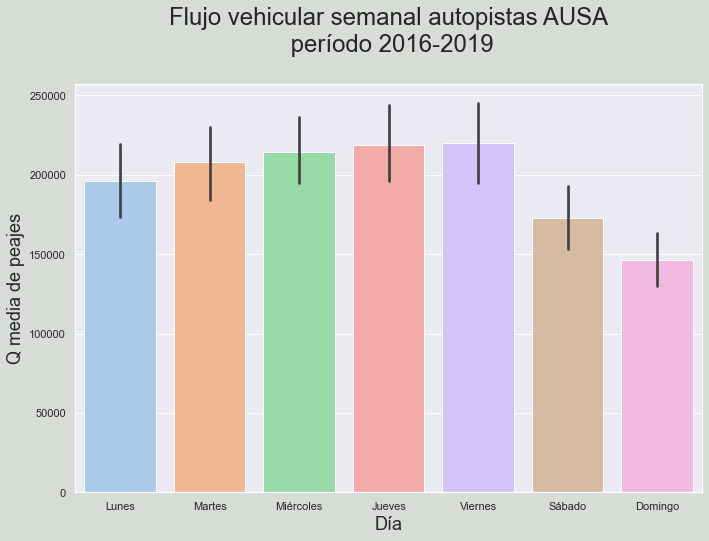

In [9]:
weekly_fv= dataset.groupby(['dia']).resample('D', on='fecha')['cantidad_pasos'].sum().reset_index()
plt.figure(figsize = (10,7), facecolor='#d8dcd6')
ax = sns.barplot(x='dia', y='cantidad_pasos', data=weekly_fv,
    order= ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'],
    palette='pastel')
plt.title('Flujo vehicular semanal autopistas AUSA\n período 2016-2019\n', fontsize=24)
plt.xlabel('Día', fontsize=18)
plt.ylabel('Q media de peajes', fontsize=18)

El flujo vehicular crece constante desde el lunes hasta el viernes, el pico, con cerca de 220k peajes diarios en promedio en la sumatoria de autopistas, con picos de casi 250k, y luego inicia el descenso hasta el domingo, día en que encontramos (previsiblemente), el mínimo flujo vehicular semanal, un 40% inferior respecto del máximo del viernes.

## Flujo vehicular mensual Autopistas AUSA


Text(0, 0.5, 'Q peajes (en miles)')

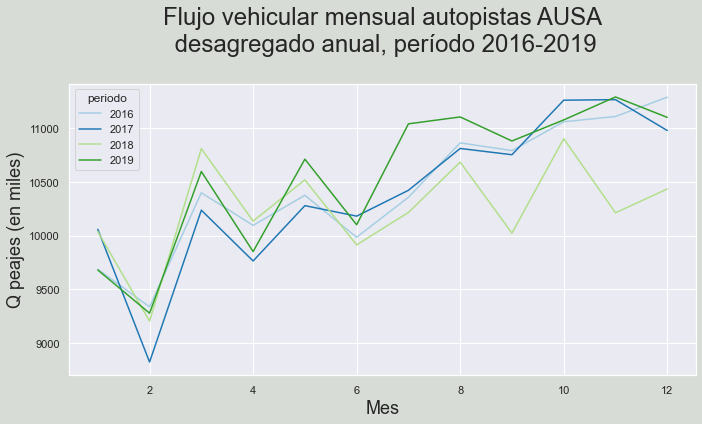

In [10]:
monthly_fv= dataset.groupby(['periodo', 'mes'])['Qk_peajes'].sum().reset_index()
plt.figure(figsize = (10,5), facecolor='#d8dcd6')
ax = sns.lineplot(x='mes', y='Qk_peajes', hue= 'periodo', data=monthly_fv, palette='Paired')
plt.title('Flujo vehicular mensual autopistas AUSA\n desagregado anual, período 2016-2019\n', fontsize=24)
plt.xlabel('Mes', fontsize=18)
plt.ylabel('Q peajes (en miles)', fontsize=18)

Al margen de la evidente estacionalidad (ya probada en proyecto 3), dos cosas adicionales para decir:
- **EL SERRUCHO**: Todas las series tienen el mismo comportamiento (intercalan descenso y ascenso) hasta octubre inclusive
- **EL CAOS**: Ninguna serie repite comportamiento en los dos últimos meses (2016: A-A; 2017 D-D; 2018 D-A; 2019 A-D)


Es claro que este último hallazgo es fortuito. Un año más en el dataset bastaría para romper esta anécdota. Quizás sí convenga a futuro mirar más detenidamente. 

## ¿Se netea mensualmente el flujo vehicular en ambos sentidos?, ¿cómo es su evolución?

En el punto 2.4 observamos el flujo vehicular por hora en días laborables en autopistas de AUSA. Pero, en el agregado, ¿cómo queda el neto? ¿Las autopistas se usan más en un sentido que en otro?. Miremos mensualmente.

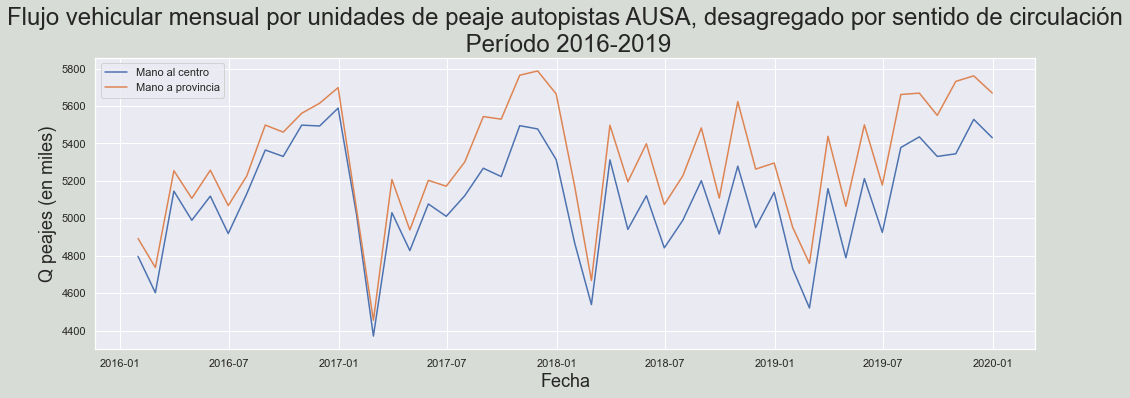

In [11]:
#máscara x sentido
Centro = dataset[(dataset['sentido']=='Centro')]
Provincia = dataset[(dataset['sentido']=='Provincia')]

#Resampleamos a mes
mes_Centro = Centro.resample('M', on = 'fecha').sum()
mes_Provincia = Provincia.resample('M', on = 'fecha').sum()

#Graficamos las series
plt.figure(figsize = (15,5), facecolor='#d8dcd6')
plt.plot(mes_Centro.index, mes_Centro.Qk_peajes, label = 'Mano al centro')
plt.plot(mes_Provincia.index, mes_Provincia.Qk_peajes, label = 'Mano a provincia')
plt.title('Flujo vehicular mensual por unidades de peaje autopistas AUSA, desagregado por sentido de circulación\n Período 2016-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Q peajes (en miles)', fontsize=18)
plt.legend()
plt.show()

**El flujo vehicular neto en AUSA es siempre a favor de mano provincia**. Miremos en Illia

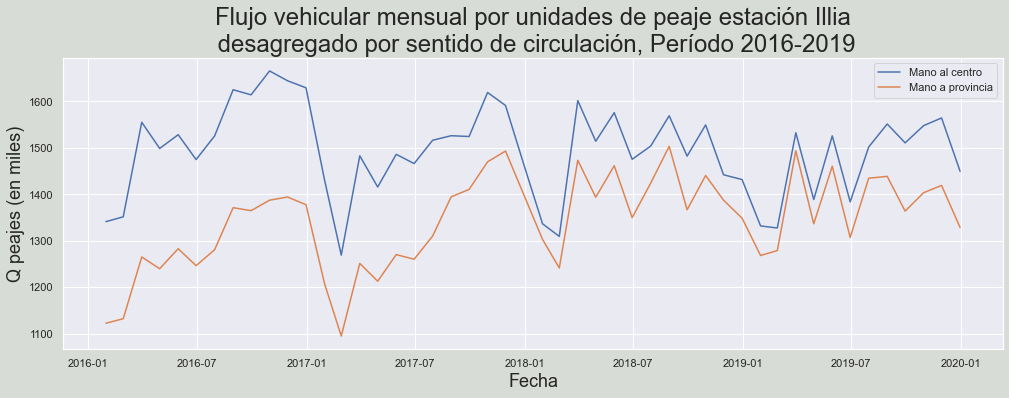

In [12]:
#máscara x sentido
illia_Centro = dataset[(dataset['sentido']=='Centro') & (dataset['estacion']=='Illia')]
illia_Provincia = dataset[(dataset['sentido']=='Provincia') & (dataset['estacion']=='Illia')]

#Resampleamos a mes
illia_mes_Centro = illia_Centro.resample('M', on = 'fecha').sum()
illia_mes_Provincia = illia_Provincia.resample('M', on = 'fecha').sum()

#Graficamos
plt.figure(figsize = (15,5), facecolor='#d8dcd6')
plt.plot(illia_mes_Centro.index, illia_mes_Centro.Qk_peajes, label = 'Mano al centro')
plt.plot(illia_mes_Provincia.index, illia_mes_Provincia.Qk_peajes, label = 'Mano a provincia')
plt.title('Flujo vehicular mensual por unidades de peaje estación Illia\n desagregado por sentido de circulación, Período 2016-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Q peajes (en miles)', fontsize=18)
plt.legend()
plt.show()

Es **exactamente lo opuesto**. Y como ya mencionamos en el proyecto 3, y en contraste con el análisis en AUSA, la **dinámica de esa diferencia cambia en el tiempo**. Vamos a graficar el neto.

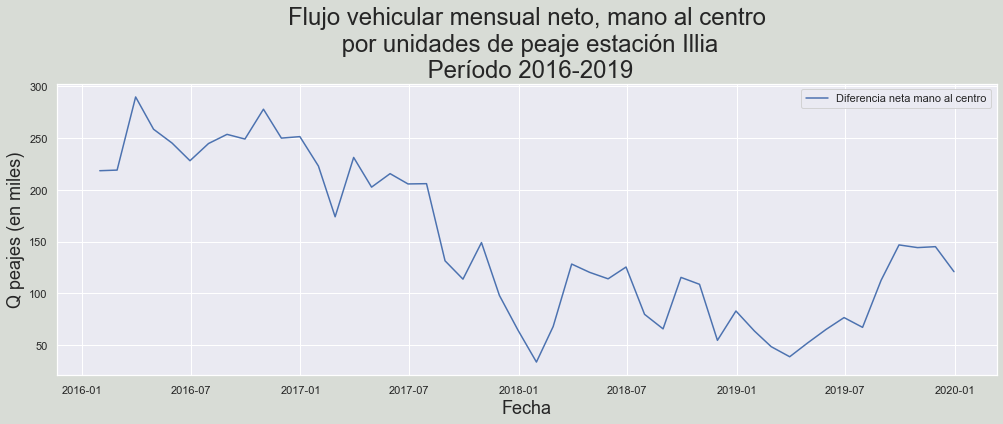

In [13]:
#Creamos una variable con la diferencia
illia_mes_Centro ['diferencia']= illia_mes_Centro ['Qk_peajes'] - illia_mes_Provincia['Qk_peajes']

#Graficamos
plt.figure(figsize = (15,5), facecolor='#d8dcd6')
plt.plot(illia_mes_Centro.index, illia_mes_Centro.diferencia, label = 'Diferencia neta mano al centro')
plt.title('Flujo vehicular mensual neto, mano al centro\n por unidades de peaje estación Illia\n Período 2016-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Q peajes (en miles)', fontsize=18)
plt.legend()
plt.show()

No es dificil imaginar una **curva convexa al origen, con una casi tangencia en el início de 2018**. ¿A qué se debe ese comportamiento? Vamos a **comparar con autopista Dellepiane, la más similar** en cuanto a volumen de flujo vehicular.

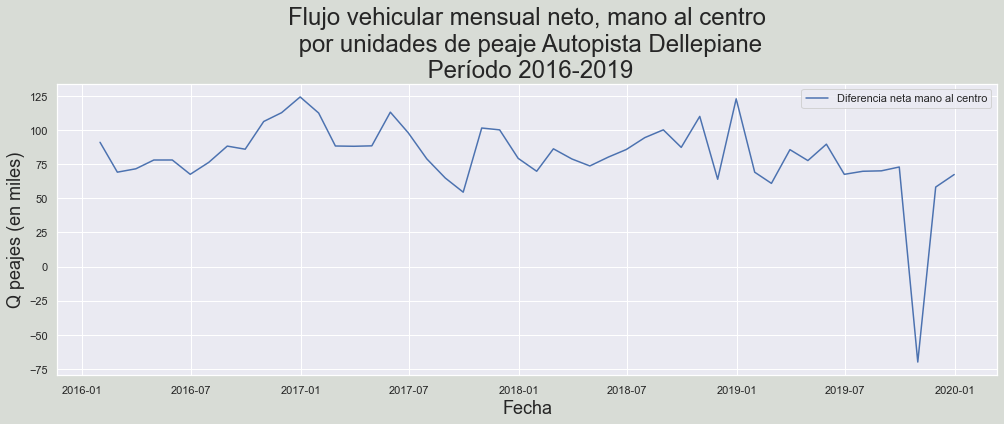

In [14]:
#máscara x sentido
Dellepiane_Centro = dataset[(dataset['sentido']=='Centro') & (dataset['estacion']=='Dellepiane')]
Dellepiane_Provincia = dataset[(dataset['sentido']=='Provincia') & (dataset['estacion']=='Dellepiane')]

#Resampleamos a mes
Dellepiane_mes_Centro = Dellepiane_Centro.resample('M', on = 'fecha').sum()
Dellepiane_mes_Provincia = Dellepiane_Provincia.resample('M', on = 'fecha').sum()

#Creamos una variable con la diferencia
Dellepiane_mes_Centro ['diferencia']= Dellepiane_mes_Centro ['Qk_peajes'] - Dellepiane_mes_Provincia['Qk_peajes']

#Graficamos
plt.figure(figsize = (15,5), facecolor='#d8dcd6')
plt.plot(Dellepiane_mes_Centro.index, Dellepiane_mes_Centro.diferencia, label = 'Diferencia neta mano al centro')
plt.title('Flujo vehicular mensual neto, mano al centro\n por unidades de peaje Autopista Dellepiane\n Período 2016-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Q peajes (en miles)', fontsize=18)
plt.legend()
plt.show()

Al igual que Illia, Dellepiane tiene flujo neto positivo mano al centro en toda la ventana de tiempo (salvo por el registro anómalo de noviembre 2019), pero **a diferencia de la Illia, ese flujo neto positivo mano al centro es estable**. Cualquier evento económico (costo de combustible o de tarifa de peaje), habría afectado a ambas autopistas por igual. Lo que sucede con la estación Illia evidentemente corresponde a una particularidad de aquella.

## ¿Ampliar la banda horaria de hora pico consigue el objetivo buscado de alterar la distribución horaria vehicular?

**INVESTIGACIÓN**


*Las tarifas segmentadas de acuerdo a las nuevas franjas horarias y a la modalidad de pago utilizada buscan generar incentivos para que el flujo de vehículos sea más uniforme durante todo el día, evitando congestiones durante las horas pico*
(portal HOYMERCEDES, 17/02/2017)
https://www.hoymercedes.com.ar/principal/2017/02/15/entran-en-vigencia-nuevos-horarios-y-valores-en-los-peajes/

*Según Vialidad Nacional, el objetivo de que el peaje sea más caro en determinadas franjas es para incentivar a los usuarios a que elijan otros horarios de menor demanda para viajar, y así se distribuya mejor el tránsito a lo largo del día* 
(nota Cinthia Ruth para Infobae, 21 de Abril de 2019) 
https://www.infobae.com/sociedad/2019/04/21/cobros-extra-de-hasta-el-40-en-los-peajes-a-la-hora-pico-se-suman-otras-medidas-que-generan-mas-polemica/

¿Podemos verificar si, efectivamente, la ampliación de la banda de hora pico cambia la distribución del flujo vehicular? Debemos ubicar una hora específica del día que haya cambiado de *hora no pico* a *hora pico* (de 19:01hs a 20:00hs). Nos inclinamos por un análisis sencillo: independientemente del crecimiento o disminución en el tiempo de la cantidad total de peajes, interesa si el porcentual de vehículos por hora se ve modificado.

C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


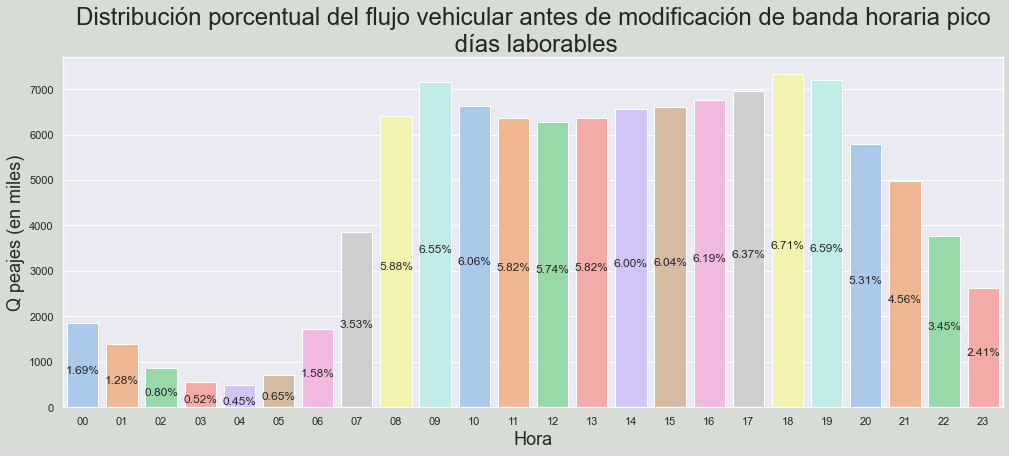

In [15]:
#Resampleo horario (agrupo flujo x hora/dia)
data_1= dataset.resample('H', on='fecha').sum()

#Necesito trabajar sólo con dias laborables. Creo nueva variable 'dia de la semana', y filtro los días necesarios
data_1['fecha_2'] = pd.to_datetime(data_1.index)
data_1['dayofweek'] = data_1['fecha_2'].dt.dayofweek
mask= data_1.loc[data_1['dayofweek'] < 5]

#Creo una variable para registrar nuevamente la hora fin
mask['Hora'] = mask.index.strftime('%H')

#En ausencia de variable que separe en antes/despues, tengo que dividir el dataset
mask_1 = mask.loc['2016-01-01 00:00:00':'2017-02-16 23:00:00']
mask_2 = mask.loc['2017-02-17 00:00:00':]

BC= mask_1.groupby(['Hora'])['Qk_peajes'].sum().reset_index()

plt.figure(figsize = (15,6), facecolor='#d8dcd6')
ax = sns.barplot(x='Hora', y='Qk_peajes', data=BC, palette='pastel')

abs_values = BC['Qk_peajes'].values
rel_values = abs_values / abs_values.sum(axis=0, keepdims=True) * 100

labels = zip(abs_values.T.flatten(), rel_values.T.flatten())

for path in ax.patches:
    abs_value, rel_value = next(labels)
    label = f"{rel_value:.2f}%"
    width, height = path.get_width(), path.get_height()
    x, y = path.get_xy()
    ax.text(x=x + width / 2,
        y=y + height / 2,
        s=label,
        horizontalalignment='center',
        verticalalignment= 'top'
        )
plt.title('Distribución porcentual del flujo vehicular antes de modificación de banda horaria pico\n días laborables', fontsize=24)
plt.xlabel('Hora', fontsize=18)
plt.ylabel('Q peajes (en miles)', fontsize=18)
plt.show()

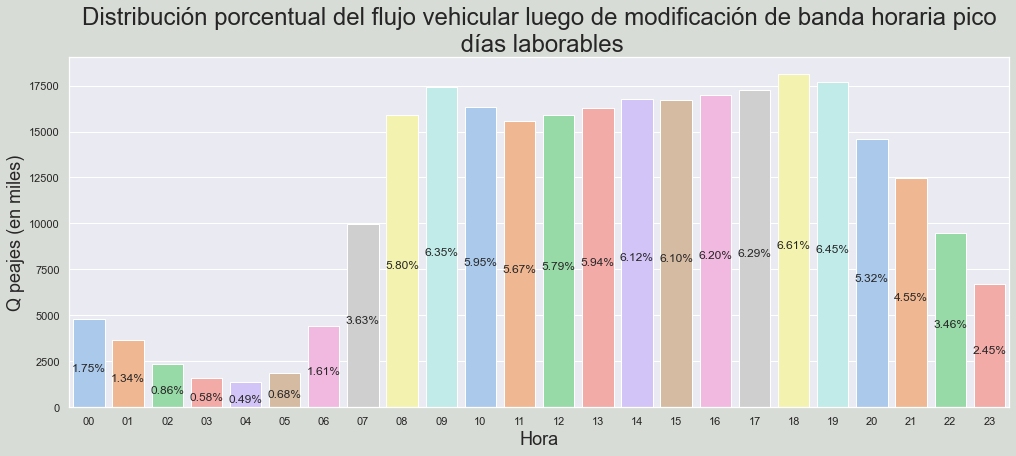

In [16]:
AC= mask_2.groupby(['Hora'])['Qk_peajes'].sum().reset_index()

plt.figure(figsize = (15,6), facecolor='#d8dcd6')
ax = sns.barplot(x='Hora', y='Qk_peajes', data=AC, palette='pastel')

abs_values = AC['Qk_peajes'].values
rel_values = abs_values / abs_values.sum(axis=0, keepdims=True) * 100

labels = zip(abs_values.T.flatten(), rel_values.T.flatten())

for path in ax.patches:
    abs_value, rel_value = next(labels)
    label = f"{rel_value:.2f}%"
    width, height = path.get_width(), path.get_height()
    x, y = path.get_xy()
    ax.text(x=x + width / 2,
        y=y + height / 2,
        s=label,
        horizontalalignment='center',
        verticalalignment= 'top'
        )
plt.title('Distribución porcentual del flujo vehicular luego de modificación de banda horaria pico\n días laborables', fontsize=24)
plt.xlabel('Hora', fontsize=18)
plt.ylabel('Q peajes (en miles)', fontsize=18)
plt.show()

El método es un poco ortodoxo, pero sirve para el fin buscado. **Antes de la modificación de la banda horaria, un 5,31% del flujo vehicular diario circulaba entre las 19:00 y 19:59. Luego del cambio, ese porcentaje no se modificó (5,32%)**. Asimismo, **si la medida fuese efectiva, debería crecer el flujo vehicular a partir de las 20hs (registrado en hora fin 21hs), escapando de la hora pico. Eso tampoco sucedió**. Antes y después del cambio, a lo largo de las 20hs, el flujo vehicular fue 4,56% y 4,55%, respectivamente. 

# **Preprocesamiento**

Realizaremos dos tareas:
- Verificar la existencia de datos faltantes (fecha o cantidad de pasos)
- Verificar outliers

En caso de existir alguno de los anteriores, vamos a usar la función interpolate() o un filtro Hampel. Vale aclarar que no todos los modelos precisan del depurado. Prophet, por ejemplo, trabaja bien con datos faltantes y outliers. Asimismo, los modelos ARIMA y SARIMA requieren de conocer el orden de diferenciación para volver estacionaria la serie, tarea que formaría parte del preprocesamiento. Volveremos a esto cuando trabajemos cada punto. 

Vamos a realizar el filtrado para estación Illia y pago en efectivo, y quitar columnas que ya no utilizaremos

In [17]:
dataset_illia = dataset[(dataset['estacion']=='Illia') & (dataset['forma_pago']=='EFECTIVO')]

In [18]:
dataset_illia

periodo  hora_inicio  hora_fin      dia estacion    sentido  \
1700       2016            3         4  Viernes    Illia     Centro   
1703       2016            3         4  Viernes    Illia     Centro   
1708       2016            3         4  Viernes    Illia     Centro   
1711       2016            4         5  Viernes    Illia     Centro   
1712       2016            4         5  Viernes    Illia     Centro   
...         ...          ...       ...      ...      ...        ...   
812010     2019           21        22   Martes    Illia  Provincia   
812016     2019           21        22   Martes    Illia  Provincia   
812080     2019           22        23   Martes    Illia     Centro   
812085     2019           22        23   Martes    Illia  Provincia   
812131     2019           23         0   Martes    Illia     Centro   

       tipo_vehiculo forma_pago  cantidad_pasos               fecha  mes  \
1700         Liviano   EFECTIVO               3 2016-01-01 04:00:00    1   
1703         Liviano   EFECTIVO             446 2016-01-01 04:00:00    1   
1708          Pesado   EFECTIVO               8 2016-01-01 04:00:00    1   
1711         Liviano   EFECTIVO              10 2016-01-01 05:00:00    1   
1712         Liviano   EFECTIVO             396 2016-01-01 05:00:00    1   
...              ...        ...             ...                 ...  ...   
812010       Liviano   EFECTIVO             556 2019-12-31 22:00:00   12   
812016        Pesado   EFECTIVO               1 2019-12-31 22:00:00   12   
812080       Liviano   EFECTIVO             214 2019-12-31 23:00:00   12   
812085       Liviano   EFECTIVO             190 2019-12-31 23:00:00   12   
812131       Liviano   EFECTIVO               4 2019-12-31 00:00:00   12   

        Qk_peajes  
1700        0.003  
1703        0.446  
1708        0.008  
1711        0.010  
1712        0.396  
...           ...  
812010      0.556  
812016      0.001  
812080      0.214  
812085      0.190  
812131      0.004  

[346566 rows x 12 columns]

## Datos faltantes

Aquí veremos si algún valor es nulo (Nan o "_")

In [19]:
dataset_illia.isnull().sum()

periodo           0
hora_inicio       0
hora_fin          0
dia               0
estacion          0
sentido           0
tipo_vehiculo     0
forma_pago        0
cantidad_pasos    0
fecha             0
mes               0
Qk_peajes         0
dtype: int64

No hay valores nulos o faltantes. Nos queda ver si faltan días. Vamos a definir una variable que registre la distancia entre registros. Si hubiese algún valor >1, significaría que falta alguno.

In [20]:
#Resampleamos a diario
dataset_illia_diario = dataset_illia.resample('D', on='fecha').sum()

#Creamos variable que enumera los días
dataset_illia_diario['fecha_numeros']=dataset_illia_diario.index.map(datetime.datetime.toordinal)

#Creamos la variable que verifica la distancia entre días
dataset_illia_diario['date_check'] = dataset_illia_diario.fecha_numeros.diff()
dataset_illia_diario.date_check.value_counts()

1.0    1460
Name: date_check, dtype: int64

**No faltan registros diarios**. Vamos a mirar outliers. 

## Outliers

Vamos a graficar para identificar valores atípicos 

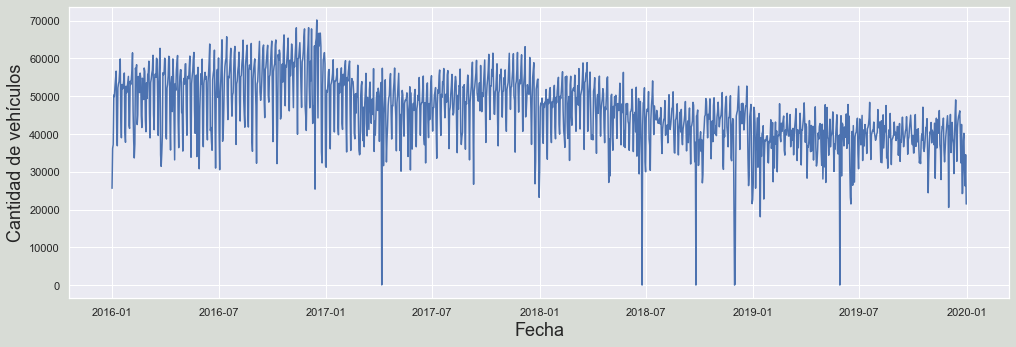

In [21]:
plt.figure(figsize = (15,5), facecolor='#d8dcd6')
sns.lineplot(x='fecha', y='cantidad_pasos', data=dataset_illia_diario)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de vehículos', fontsize=18)
#plt.xlim(datetime.date(2017,4,1), datetime.date(2017,4,9))
#plt.ylim(20000,70000)
#plt.legend()
plt.show()

Observamos valores cercanos a cero. Hacemos una máscara para detectarlos.

In [22]:
mask_0= dataset_illia_diario[(dataset_illia_diario['cantidad_pasos']<=10000)]
mask_0

periodo  hora_inicio  hora_fin  cantidad_pasos  mes  Qk_peajes  \
fecha                                                                        
2017-04-06     6051            0         3              40   12       0.04   
2018-06-25        0            0         0               0    0       0.00   
2018-09-25        0            0         0               0    0       0.00   
2018-11-30        0            0         0               0    0       0.00   
2018-12-01    22198          249        92             350  132       0.35   
2019-05-29        0            0         0               0    0       0.00   

            fecha_numeros  date_check  
fecha                                  
2017-04-06         736425         1.0  
2018-06-25         736870         1.0  
2018-09-25         736962         1.0  
2018-11-30         737028         1.0  
2018-12-01         737029         1.0  
2019-05-29         737208         1.0

Tenemos huelgas de actividad, así como eventos asociados a la cumbre del G20. Tenemos el mismo resultado que en proyecto 3.

Voy a utilizar un filtro Hampel. El punto no sería sólo sacar valores "extremos", sino aquellos que, sin ser aberrantes, respondan a comportamientos fuera de un límite lógico. Le doy una ventana lo suficientemente grande (10 días), y hasta 4 desvíos estandard, para asegurar de quitar valores anómalos. Al final, graficamos la serie original y la preprocesada.

In [23]:
#Creamos la función para correr el filtro
def hampel_filter_forloop(input_series, window_size, n_sigmas=4):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    
    indices = []
    
    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):
        x0 = np.median(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

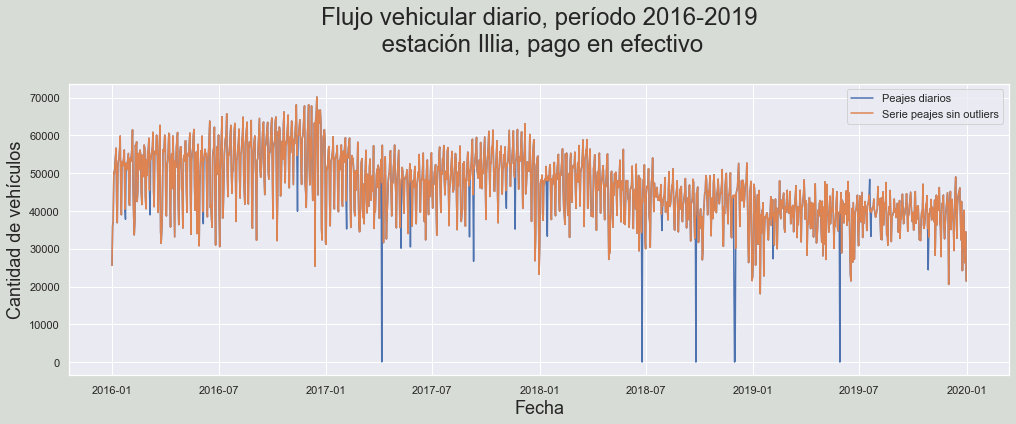

In [24]:
#Llamamos la función creada
res, detected_outliers = hampel_filter_forloop(dataset_illia_diario.cantidad_pasos, 10)

#creamos nueva variable con los peajes tratados por outliers
dataset_illia_diario['cantidad_peajes'] = res

#Graficamos la serie original y la preprocesada
plt.figure(figsize = (15,5), facecolor='#d8dcd6')
plt.plot(dataset_illia_diario.index, dataset_illia_diario.cantidad_pasos, label = 'Peajes diarios')
plt.plot(dataset_illia_diario.index, dataset_illia_diario.cantidad_peajes, label = 'Serie peajes sin outliers')
plt.title('Flujo vehicular diario, período 2016-2019\n estación Illia, pago en efectivo\n', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de vehículos', fontsize=18)
plt.legend()
plt.show()

Vemos que el filtro elimina los outliers detectados anteriormente. Adicionalmente, quita otra veintena de valores que no pasan el filtro.

Hay **otras acciones para el preprocesamiento** (como la normalización de la media y la varianza), **pero estas dependen que tratemos con una serie no estacionaria**. Volveremos a ello más adelante.

# **Tendencia, estacionalidad y ruido**


Iniciamos con un análisis de rolling window sobre la media y el desvío estandar. Luego descompondremos la serie con la función de statsmodels.

Como hicimos en el proyecto 3, vamos a trabajar con resampleo semanal para quitar ruido de la serie. La importancia del resampleo diario se planteará para los modelos de estacionalidad compleja.

In [25]:
dataset_illia_diario.head(367)

periodo  hora_inicio  hora_fin  cantidad_pasos   mes  Qk_peajes  \
fecha                                                                         
2016-01-01   409248         2671      2634           25602   203     25.602   
2016-01-02   510048         2923      2936           36136   253     36.136   
2016-01-03   514080         3099      3066           37225   255     37.225   
2016-01-04   566496         3316      3357           50312   281     50.312   
2016-01-05   562464         3401      3392           49907   279     49.907   
...             ...          ...       ...             ...   ...        ...   
2016-12-28   673344         3916      4010           60291  4008     60.291   
2016-12-29   639072         3746      3775           61551  3804     61.551   
2016-12-30   641088         3659      3737           58601  3816     58.601   
2016-12-31   528192         2764      3002           31527  3144     31.527   
2017-01-01   465927         3033      2976           31183   231     31.183   

            fecha_numeros  date_check  cantidad_peajes  
fecha                                                   
2016-01-01         735964         NaN            25602  
2016-01-02         735965         1.0            36136  
2016-01-03         735966         1.0            37225  
2016-01-04         735967         1.0            50312  
2016-01-05         735968         1.0            49907  
...                   ...         ...              ...  
2016-12-28         736326         1.0            60291  
2016-12-29         736327         1.0            61551  
2016-12-30         736328         1.0            58601  
2016-12-31         736329         1.0            31527  
2017-01-01         736330         1.0            31183  

[367 rows x 9 columns]

In [26]:
#Resampleamos a semanal
dataset_illia_W = dataset_illia_diario.resample ('W').sum()
#Dropeamos columnas
dataset_illia_W = dataset_illia_W.drop(columns=['periodo', 'hora_inicio', 'hora_fin', 
                    'cantidad_pasos', 'mes', 'Qk_peajes','fecha_numeros', 'date_check',])
dataset_illia_W.head()

cantidad_peajes
fecha                      
2016-01-03            98963
2016-01-10           342201
2016-01-17           359649
2016-01-24           360963
2016-01-31           348221

## Análisis de la serie con rolling window

Aún no hablamos de modelos. Muchos de ellos requieren series estacionarias para poder trabajar eficientemente, es decir, media, varianza, y covarianza constante. Los modelos AR(), MA, y ARMA, son algunos de ellos. Con series no estacionarias (con tendencia), el ARIMA funciona mejor, ya que incorpora dentro de sus parámetros la posibilidad de indicar el grado de diferenciación necesario para tornar estacionaria la serie con tendencia, evitando la autocorrelación. Pero no acepta series con estacionalidad. Aquí es dónde entra el SARIMA. Parte de los análisis que siguen tienen la intención de demostrar que se posee una acabada comprensión de los temas tratados, pero, adicionalmente, que se entiende que ciertos tipos de transformaciones y análisis sólo tienen sentido en presencia de las barreras antes detalladas. Es por ello que iniciamos esta sección con una sómera revisión de la naturaleza de la media y el desvío estandar de la serie, en la búsqueda de establecer con claridad si ésta es o no estacionaria. Luego de ello, realizaremos las transformaciones necesarias para tomar de ellas los datos requeridos para ciertos modelos. Vale aclarar, al respecto, que Prophet no precisa de este desarrollo, y TBATS los realiza en función del mejor score.  

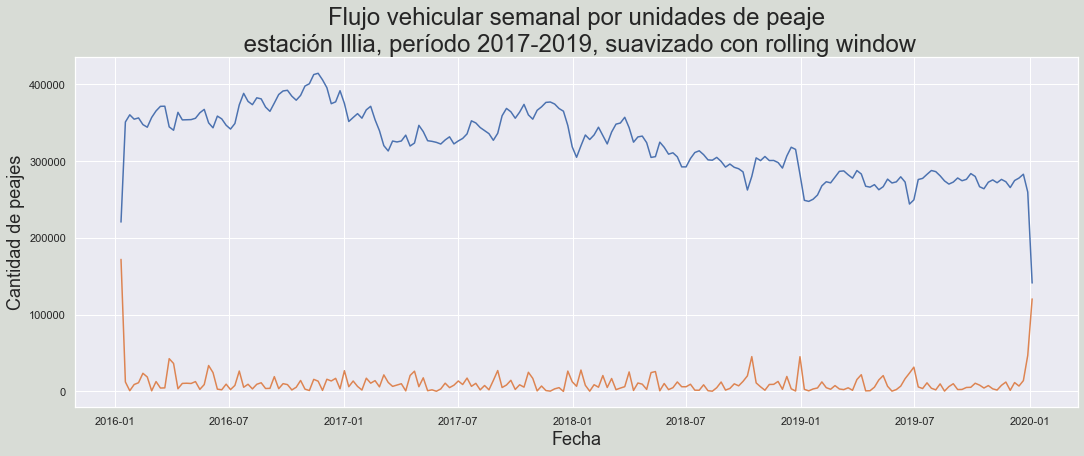

In [27]:
plt.figure(figsize=(16,6), facecolor='#d8dcd6')
plt.plot(dataset_illia_W.cantidad_peajes.rolling(window=2,center=False).mean(),label='Rolling Mean');
plt.plot(dataset_illia_W.cantidad_peajes.rolling(window=2,center=False).std(),label='Rolling sd');
plt.title('Flujo vehicular semanal por unidades de peaje\n estación Illia, período 2017-2019, suavizado con rolling window', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
#threshold_date = pd.to_datetime('2018-03-29')
#plt.axvline(threshold_date, color='red', linestyle='--', label='train test split')
plt.show()

**La serie parece mostrar una tendencia descendente para la ventana de 4 años, pero el comportamiento es un tanto irregular al interior de ella**. El 2016 parece tener tendencia ascendente, y lo opuesto durante 2017 y 2018, para luego parecer estacionaria en 2019. El desvío estandard parece haberse mantenido estable. A priori, ¿estamos hablando de una serie no estacionaria? Vamos a produndizar en este análisis.

## ¿Es estacionaria la serie?

Hay **varias formas de responder a esta pregunta**. Intuitívamente, basta con mirar los gráficos, en búsqueda de ausencia de una tendencia o de estacionalidad. Para nuestro caso, y en diversas oportunidades, ya observamos que no parece ser el caso (ver gráfico precedente, por ejemplo). 

De entre los **métodos matemáticos, el *Augmented Dickey–Fuller test* y el Kwiatkowski-Phillips-Schmidt-Shin test sirven para verificar, por vías distintas, si la serie no posee tendencia**, y con ello, si la variación en Yt se explica sólo por el componente de ruido. Sin embargo, como veremos, **el resultado puede ser contradictorio**. 

Vamos a probar el **ADF test con un 95% de significancia. La Ho es que la serie presenta raíz unitaria, y con ello, que no es estacionaria**. Si el p-value da por dabajo de 0,05, entonces rechazamos la hipótesis nula, y aceptamos que la serie es estacionaria. En cuanto a transformación de los datos, el resampleo a mensual ayuda a quitar ruido, por lo que de momento no realizaremos preprocesamiento.

In [28]:
#AUgmented Dicki-Fuller test
from statsmodels.tsa.stattools import adfuller
adf = adfuller(dataset_illia_W['cantidad_peajes'], regression= 'ct')
print("p-value: {}".format(float(adf[1])))

p-value: 7.098073707428748e-15


Para el ADF test **rechazamos la H0, por lo tanto, aceptamos la HA de que la serie es estacionaria** (no tiene raíz unitaria). Pero esto **parece contrafáctico**. 

**Veamos ahora el kpss test. Aquí, Ho e HA se invierten**. Si el p-value < 0,05, entonces rechazamos la Ho, y aceptamos la hipótesis alternativa de que la serie es no-estacionaria.

In [29]:
from statsmodels.tsa.stattools import kpss
kpss = kpss(dataset_illia_W['cantidad_peajes'], regression= 'ct')
print("p-value: {}".format(float(kpss[1])))

p-value: 0.037779712831019316


C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


Y aquello es lo que sucede. **Según el kpss test, la serie es no estacionaria. ¿A que se debe esta contradicción entre los test? Posiblemente, a que la serie tiene quiebre de tendencia**, una suerte de punto (o puntos) de inflexión. Para comprobar esto, **vamos a repetir los tests, pero separando la serie de tiempo en dos partes: hasta el quiebre observado en el proyecto anterior, y luego de este**.

In [30]:
#separamos los datasets
threshold_date = pd.to_datetime('2018-03-29')
mask = dataset_illia_W.index < threshold_date
df_bbt =  dataset_illia_W[mask]
df_abt = dataset_illia_W[~ mask]

In [31]:
#probamos el primer subset
adf = adfuller(df_bbt['cantidad_peajes'], regression='ct')
print("p-value ADF test: {}".format(float(adf[1])))

p-value ADF test: 0.08343982570920544


**La serie hasta 28/03/2018 sería no-estacionaria, según ADF test. Vamos a mirar el segundo subset**

In [32]:
#probamos el segundo subset
adf = adfuller(df_abt['cantidad_peajes'], regression='ct')
print("p-value ADF test: {}".format(float(adf[1])))

p-value ADF test: 0.1300662456766995


El p-value>0,05 en ADF test, por lo tanto aceptamos Ho, con lo cuál **este tramo de la serie también tiene tendencia no neutra, resultado que confirma lo que muestra el gráfico de la serie**. Sabemos que, dependiendo de la ventana de tiempo, la serie puede ser estacionaria o no, o ser contradictoria. 

Vamos a trabajar con todos los datos, asumiendo una serie no estacionaria. Para finalizar, voy a graficar la serie original (sin otliers) y otra diferenciada de orden 1, para evitar la autocorrelación. Este último dato es parámetro para los modelos ARIMA y SARIMA.

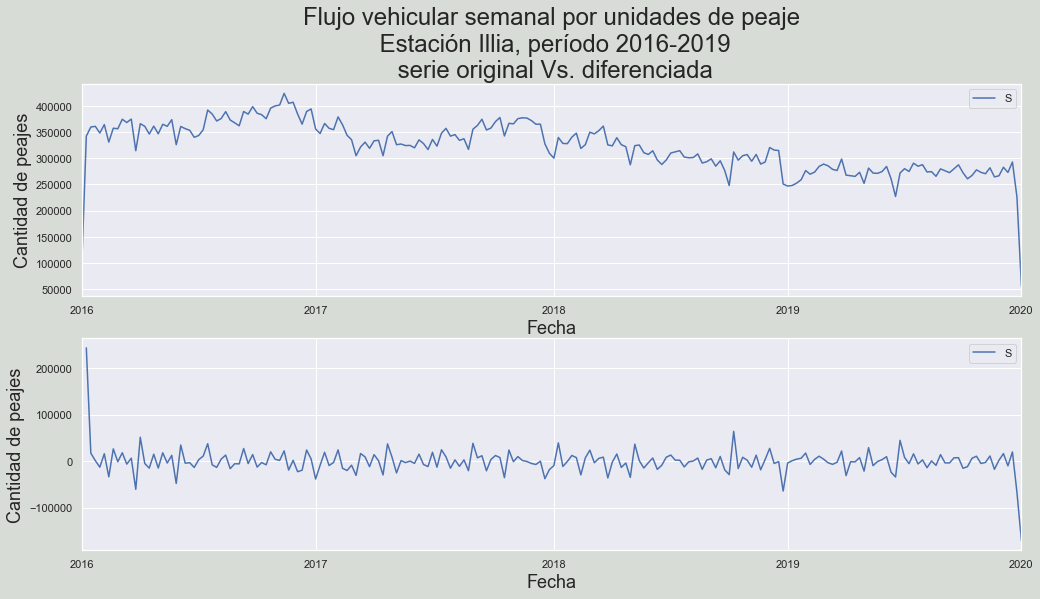

In [33]:
plt.figure(figsize=(15,8), facecolor='#d8dcd6')
plt.subplot(2,1,1)
dataset_illia_W.cantidad_peajes.plot(label='Serie original')
plt.title('Flujo vehicular semanal por unidades de peaje\n Estación Illia, período 2016-2019\n serie original Vs. diferenciada', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
plt.legend('Serie original')
plt.subplot(2,1,2)
dataset_illia_W.cantidad_peajes.diff().plot(label='Serie diferenciada')
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
plt.legend('Serie diferenciada')
plt.show()

Una diferenciación parece suficiente. Vamos a descomponer la serie.

## Descomposición con modelos de statsmodels

Vamos a usar el seasonal_decompose de statsmodel, considerando modelo aditivo, ya que asumimos que la estacionalidad tiene un claro patrón anual (la reducción del flujo vehícular en los meses de verano), y que la magnitud de esta fluctuación se mantiene contante. En period ponemos la duración del ciclo (52 semanas = 1 año)

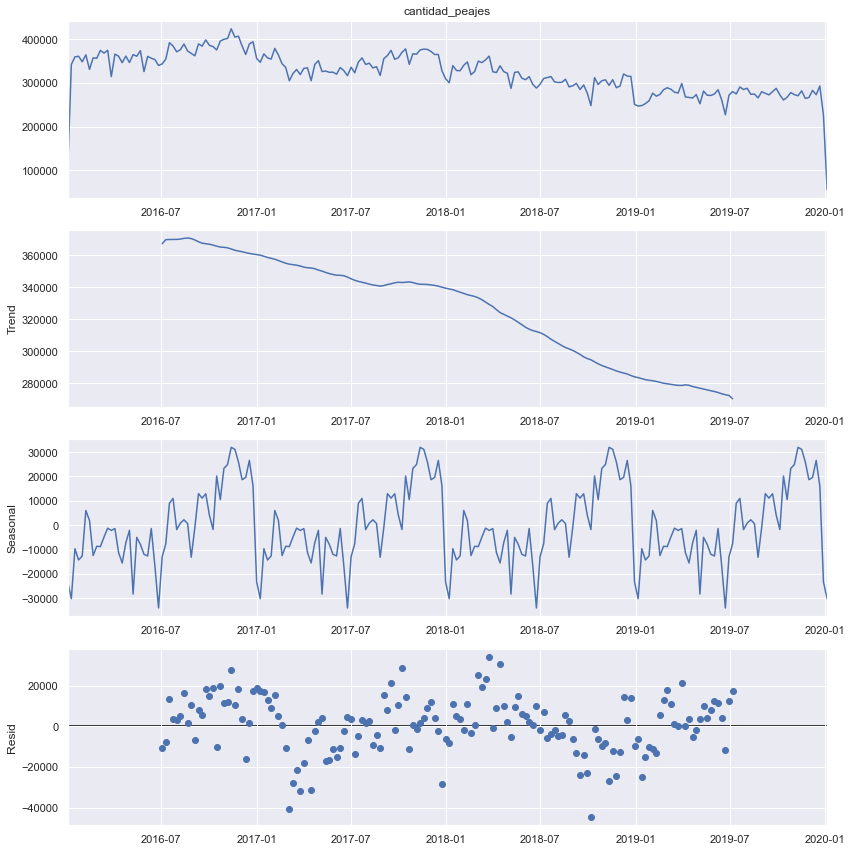

<AxesSubplot:xlabel='resid', ylabel='Density'>

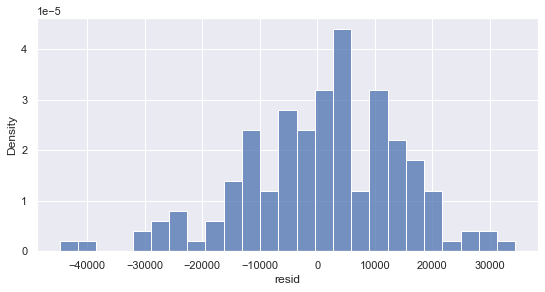

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = [12,12]

#para Seasonal decomposition using moving averages.
result_additive = seasonal_decompose(dataset_illia_W.cantidad_peajes, period=52, model='additive')
result_additive.plot()
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(result_additive.resid, stat= 'density', bins = 25, element='bars', fill=True)

El residuo no parece independiente del tiempo. Aparte de esto, la cola de la distribución tiene una cola hacia la izquierda. Recordemos esta idea: el modelo aditivo funciona cuando, en pocas palabras, las brechas entre pico y valle son constantes en el tiempo, que es lo que asumimos. Vamos a probar con un modelo multiplicativo. Luego los comparamos.

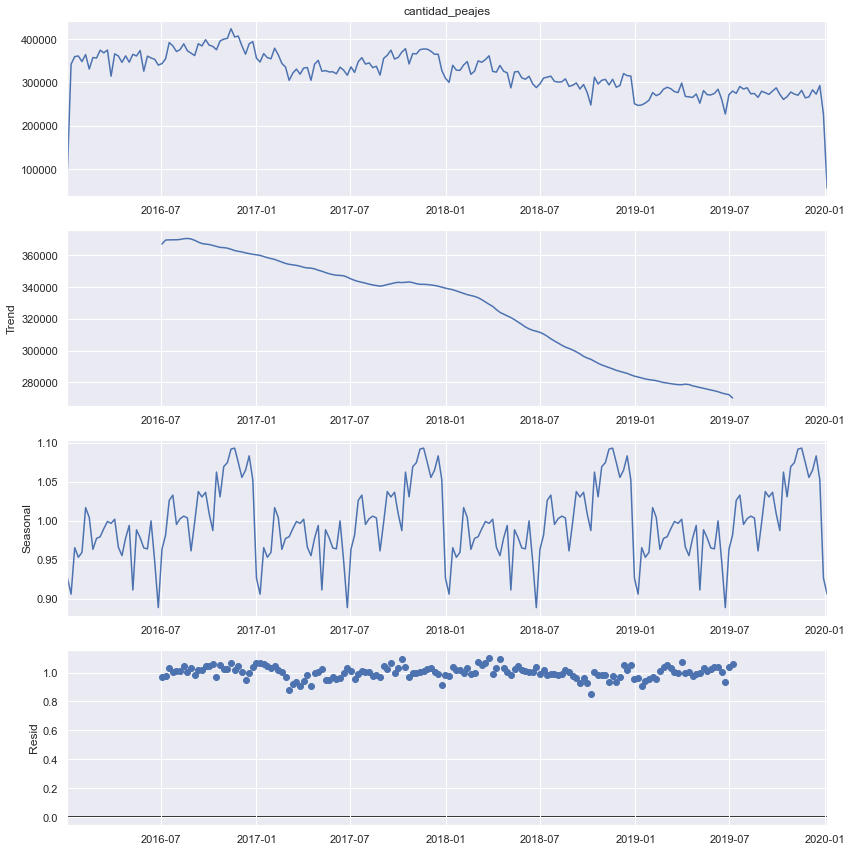

<AxesSubplot:xlabel='resid', ylabel='Density'>

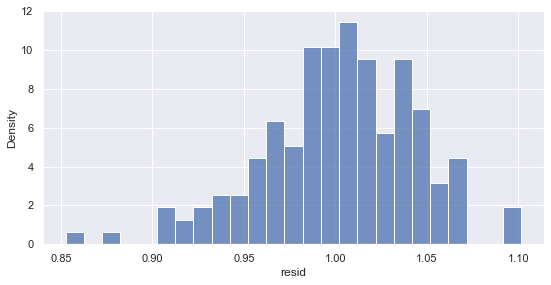

In [35]:
#para Seasonal decomposition con modelo multiplicativo.
#plt.rcParams['figure.figsize'] = [8,8]
result_multiplicative = seasonal_decompose(dataset_illia_W.cantidad_peajes, period=52, model='multiplicative')
result_multiplicative.plot()
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(result_multiplicative.resid, stat= 'density', bins = 25, element='bars', fill=True)

Con el modelo multiplicativo los residuos parecen más independientes del tiempo. La distribución aún se percibe con cola a la izquierda, pero más armonizada que en el caso del modelo aditivo.

# **Autocorrelación y Autocorrelación Parcial**

*In particular, autocorrelation
asks the more general question of whether there is a correlation between
any two points in a specific time series with a specific fixed distance between them* (Nielsen, 2020).

La predicción en series temporales implica asumir que, en gran medida, el futuro se comportará como el pasado. Una forma de observar en que grado esto es cierto, es observando la autocorrelación, y la autocorrelación parcial. La autocorrelación, como se desprende del nombre, es la correlación de los valores de la serie con los valores adoptados por la misma serie, pero en períodos anteriores (lags). La autocorrelación parcial nos permite medir la dependencia entre dos puntos distintos de la serie, neutralizando los efectos de los lags entre ellos.

Asimismo, los análisis de autocorrelación y autocorrelación parcial son insumo para modelos de tipo ARMA, ARIMA, y SARIMA, casa uno con sus particularidades. En nuestro caso, el modelo aplicable es el SARIMA, por las razones antes expuestas. Por ahora, vamos a concentrarnos en el análisis propiamente dicho. Recordemos: el primero nos permite descubrir el orden del proceso MA(), mientras que el segúndo, el del proceso AR().

Vamos a graficar ambas funciones, realizando las diferenciaciones necesarias. Para quitar tendencia realizamos 1, y otras 52 para quitar estacionalidad.

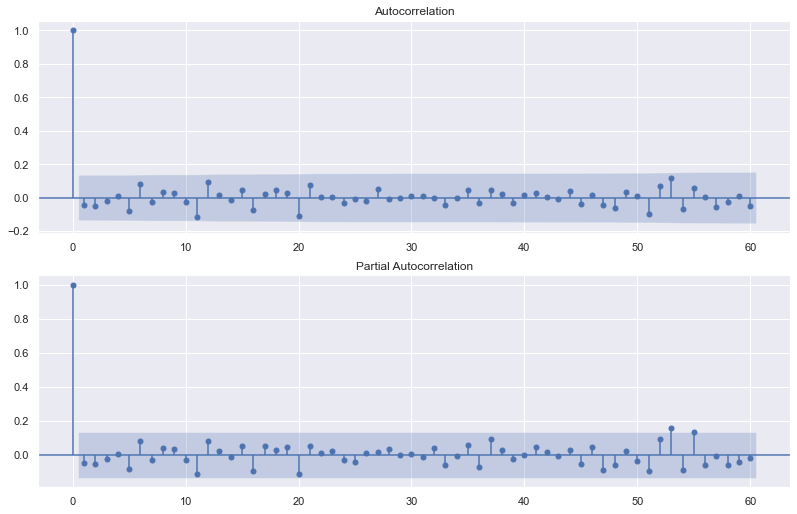

In [36]:
#Importamos las librerías
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig=plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig=plot_acf(dataset_illia_W['cantidad_peajes'].diff().dropna(), lags=60, alpha= 0.05, ax=ax1)
ax2= fig.add_subplot(212)
fig=plot_pacf(dataset_illia_W['cantidad_peajes'].diff().dropna(), lags=60, alpha= 0.05, ax=ax2)
plt.show()

En caso de modelo ARIMA, tendríamos (p, d, q) = (0, 1, 0). Ahora buscamos los parámetros para la estacionalidad. 

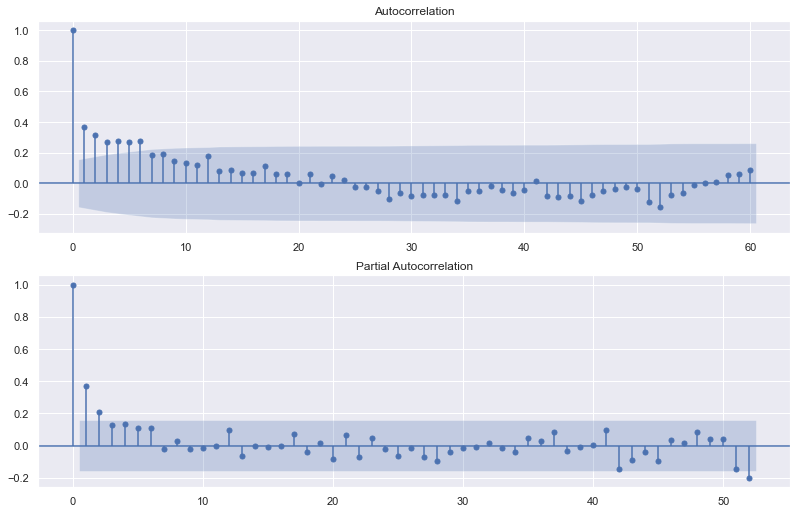

In [37]:
fig=plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig=plot_acf(dataset_illia_W['cantidad_peajes'].diff(52).dropna(), lags=60, ax=ax1)
ax2= fig.add_subplot(212)
fig=plot_pacf(dataset_illia_W['cantidad_peajes'].diff(52).dropna(), lags=52, ax=ax2)
plt.show()

Los componentes (P, D, Q)m son: (2, 1, 6)52.

Ya tenemos todos los datos para un modelo SARIMA. Vamos a pasar a la parte de modelización.

# **Modelización de la serie**

Lo que sigue se divide en **tres partes**:
- 1. Repetimos análisis de proyecto tres, con más datos. Bench, SARIMA y Prophet, y comparamos desempeño.
- 2. Trabajamos con modelos multivariados
- 3. Trabajamos con estacionalidad compleja



# **Comparativa proyecto 3: modelos con más datos**

Vamos repetir el análisis del proyecto 3, pero con más datos. Esto nos permitirá incrementar el tamaño de test, lo cuál esperamos nos permita obtener una idea más acabada de la eficiencia y consistencia de los modelos.

**Nota: el resampleo sigue siendo semanal, como en proyecto 3, para hacerlos comparables**

## El modelo benchmark 

**"a regression on past values to predict future values"** (Nielsen, 2020).

Como benchmark usaremos una regresión lineal, que simplemente nos aportará la ecuación de la recta que mejor ajuste a los datos. Es de esperar, por la poca flexibilidad del método, que obtengamos una valor de error elevado. Al respecto, a **los modelos los evaluaremos mediante RMSE y MAPE**, siendo esta última métrica la que nos permitirá comparar los distintos modelos, ya que expresa el error como porcentaje de la base. En algún caso, reformularemos su cálculo (al tratar el Random Forest).

### El modelo

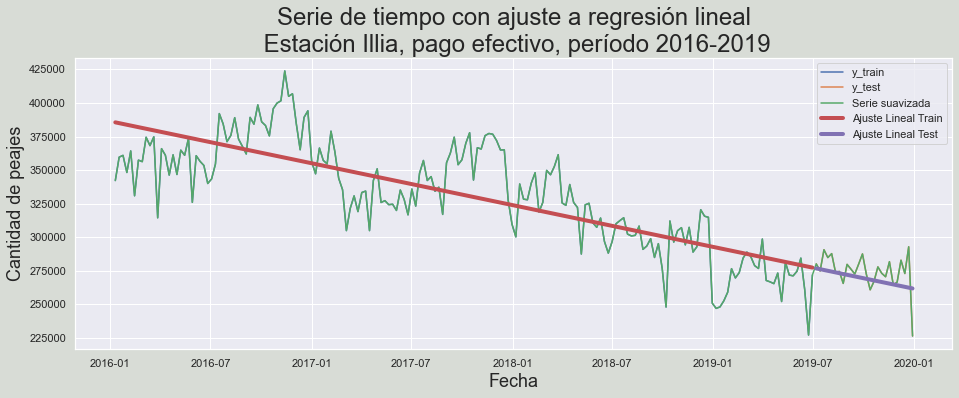

In [38]:
#Iniciamos quitando la última semana (incompleta) del dataset, para que no repercuta en el MAPE del test
dataset_illia_W.drop(dataset_illia_W.head(1).index, inplace=True)
dataset_illia_W.drop(dataset_illia_W.tail(1).index, inplace=True)

#Pasamos fechas a números
dataset_illia_W ['fecha_números'] = dataset_illia_W.index.map(datetime.datetime.toordinal)

#Separamos dataset en train/test
df_train = dataset_illia_W.loc['2016-01-10':'2019-06-30']
df_test = dataset_illia_W.loc['2019-07-01':]

#Llamamos librería, instanciamos modelo, hacemos fit y predict
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr_1 = lr.fit(df_train.fecha_números.values.reshape(-1, 1), df_train.cantidad_peajes)
y_pred_train= lr_1.predict(df_train.fecha_números.values.reshape(-1, 1))

#Graficamos
plt.figure(figsize = (14,5), facecolor='#d8dcd6')
plt.plot(df_train.index, df_train.cantidad_peajes, label = 'y_train')
plt.plot(df_test.index, df_test.cantidad_peajes, label = 'y_test')
plt.plot(dataset_illia_W.cantidad_peajes,label='Serie suavizada')
plt.plot(df_train.index, lr_1.predict(df_train.fecha_números.values.reshape(-1, 1)), lw = 4, label = 'Ajuste Lineal Train')
plt.plot(df_test.index, lr_1.predict(df_test.fecha_números.values.reshape(-1, 1)), lw = 4, label = 'Ajuste Lineal Test')
plt.title('Serie de tiempo con ajuste a regresión lineal\n Estación Illia, pago efectivo, período 2016-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
plt.legend()
plt.show()

### Evaluación del modelo

In [39]:
from sklearn.metrics import mean_squared_error

def evaluar_regresion(model, X_train, X_test, y_train, y_test):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    print(f'Porcentaje del Error Absoluto medio en Train: {mape_train}')
    print(f'Porcentaje del Error Absoluto medio en Test: {mape_test}\n')

    ### GRAFICAMOS LOS RESULTADOS
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(y_train - y_train_pred, color= 'red', bins = 20, label = 'train')
    sns.histplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()
    
def evaluar_modelo(modelo, y_train, y_test, y_train_pred, y_test_pred):

    print('El modelo a evaluar: ', modelo)
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    print(f'Porcentaje del Error Absoluto medio en Train: {mape_train}')
    print(f'Porcentaje del Error Absoluto medio en Test: {mape_test}\n')

    ### GRAFICAMOS LOS RESULTADOS
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(y_train -y_train_pred, color= 'red', bins = 20, label = 'train')
    sns.histplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test, y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
        ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

Raíz del error cuadrático medio en Train: 24220.838379020217
Raíz del error cuadrático medio en Test: 12776.777458498387
Porcentaje del Error Absoluto medio en Train: 5.8294046997429465
Porcentaje del Error Absoluto medio en Test: 3.4099635673920057



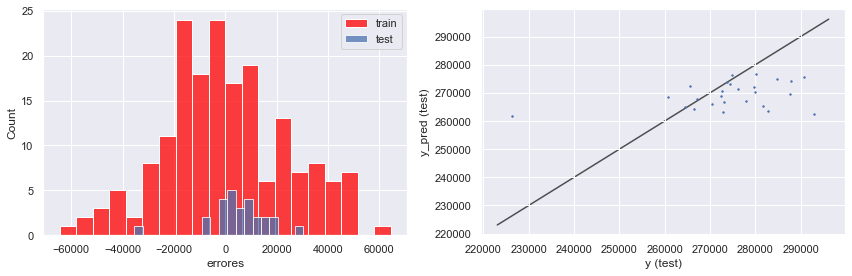

In [40]:
#llamamos la función creada para evaluar
evaluar_regresion(lr_1, df_train['fecha_números'].values.reshape(-1, 1), df_test['fecha_números'].values.reshape(-1, 1),
df_train['cantidad_peajes'], df_test['cantidad_peajes'])

Sin olvidarnos de que estamos trabajando con resampleo semanal, más datos mejoraron largamente el desempeño del modelo para el test en cuanto a las métricas de evaluación. Con el benchmark obtenemos un error promedio de **24220 - 12776 peajes semanales (RMSE)**, que representan un **5,83% - 3,41% respecto de la media (MAPE)**, para el test/train set, respectivamente. Con datos desde 2017, el desempeño fue peor (**34380 - 57062 (RMSE)**, que representan un **12% - 30,19%). Sin dudas, quitar la primera y última semana del dataset (semanas incompletas), marca una gran diferencia, pero adicionalmente, el período agregado hace de contrapeso al intervalo 2017-2018.

Los errores no parecen seguir una distribución normal, empeorando en el test. Como vemos en el gráfico datos reales vs. predichos, el modelo subestima sistemáticamente la cantidad de peajes. Esto es bastante evidente al observar el gráfico de la serie de tiempo. Aquí quizás estemos viendo el efecto de trabajar con una ventana de tiempo que parece mostrar cambio de tendencia. 

## ¿Cambia la tendencia de la serie de tiempo al incorporar años (ampliar la ventana)?

**Vamos a comparar el resultado del proyecto 3 (2017 a 2019) luego de ampliar la ventana de tiempo en un año (2016)**

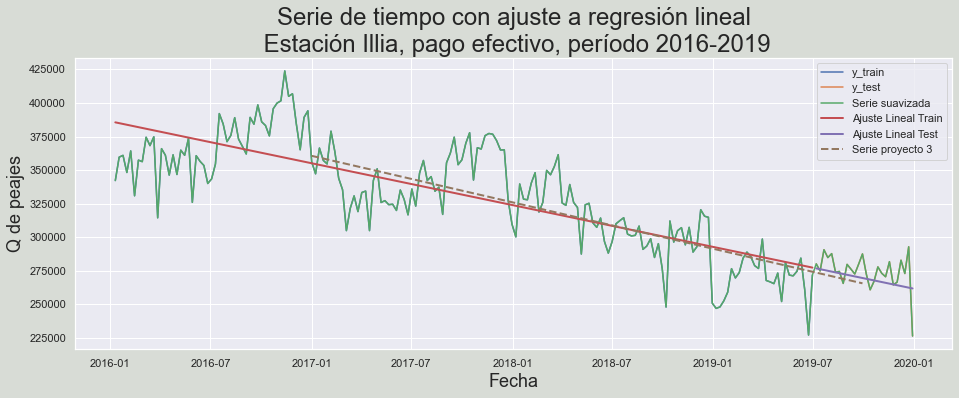

In [41]:
#Hacemos un slice en el dataset para quedarnos con el período con que entrenamos el bench del proyecto 3
df_2017 = dataset_illia_W.loc['2017-01-01': '2019-09-30']

#Creamos la nueva regresión lineal con estos datos
lr_2 = LinearRegression()
lr_2 = lr_2.fit(df_2017.fecha_números.values.reshape(-1, 1), df_2017.cantidad_peajes)
y_pred_lr_2= lr_2.predict(df_2017.fecha_números.values.reshape(-1, 1))

#Graficamos
plt.figure(figsize = (14,5), facecolor='#d8dcd6')
plt.plot(df_train.index, df_train.cantidad_peajes, label = 'y_train')
plt.plot(df_test.index, df_test.cantidad_peajes, label = 'y_test')
plt.plot(dataset_illia_W.cantidad_peajes,label='Serie suavizada')
plt.plot(df_train.index, lr_1.predict(df_train.fecha_números.values.reshape(-1, 1)), lw = 2, label = 'Ajuste Lineal Train')
plt.plot(df_test.index, lr_1.predict(df_test.fecha_números.values.reshape(-1, 1)), lw = 2, label = 'Ajuste Lineal Test')
plt.plot(df_2017.index, lr_2.predict(df_2017.fecha_números.values.reshape(-1, 1)), lw = 2, linestyle= '--', label = 'Serie proyecto 3')
plt.title('Serie de tiempo con ajuste a regresión lineal\n Estación Illia, pago efectivo, período 2016-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Q de peajes', fontsize=18)
plt.legend()
plt.show()

El método MCO en la regresión lineal permite obtener la ecuación de la recta que mejor ajusta a los datos (que minimiza los errores). La recta del proyecto actual (linea roja), contiene datos de un año adicional (2016). Este año, no tiene un visible tendencia decreciente, como el período 2017-2018. Como resultado, con la nueva ventana de cuatro años obtenemos una pendiente más suave.

## Modelo SARIMA

El modelo SARIMA, como hemos explicado, es un modelo de proceso ARMA(*) que puede ser ingestado con series de tiempo con tendencia y estacionalidad simple. Vamos a utilizar los parámetros que obtuvimos en el análisis de ACF y PACF, de modo que ya trabajaremos con un modelo optimizado.

*modelo de proceso ARMAc: combinación lineal de los valores pasados junto con los términos de error, ambos ponderados, para explicar el valor de nuestra variable en el momento t*.

In [42]:
#Quitamos la variable que no necesitamos
dataset_illia_W.drop(columns=['fecha_números'], inplace=True)

#separamos los datasets
df_train = dataset_illia_W.loc['2016-01-10':'2019-06-30']
df_test = dataset_illia_W.loc['2019-07-07':'2019-12-29'] #['cantidad_peajes']

### El modelo

In [43]:
#Importamos librerías
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Instanciamos el modelo con los hiperparámetros del punto 5, y hacemos fit.
sarima= sm.tsa.statespace.SARIMAX(df_train['cantidad_peajes'], order=(0,1,0), 
                                 seasonal_order=(2,1,6,52),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False).fit(dis=-1)

#Creamos variables para los valores predichos
y_train_pred = sarima.predict('2016-01-10','2019-06-30')
y_test_pred = sarima.predict('2019-07-07','2019-12-29')
df_train ['y_train_pred'] = y_train_pred
df_test ['y_test_pred'] = y_test_pred

C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

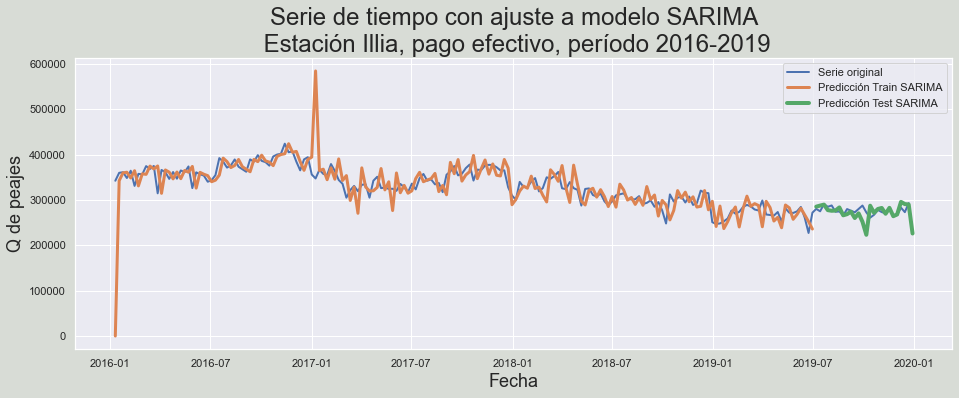

In [44]:
#Vamos a graficar la serie original y los valores predichos por el modelo
plt.figure(figsize = (14,5), facecolor='#d8dcd6')
plt.plot(dataset_illia_W.index, dataset_illia_W.cantidad_peajes, lw = 2, label = 'Serie original')
plt.plot(df_train.index, df_train.y_train_pred, lw = 3, label = 'Predicción Train SARIMA')
plt.plot(df_test.index, df_test.y_test_pred, lw = 4, label = 'Predicción Test SARIMA')
plt.title('Serie de tiempo con ajuste a modelo SARIMA\n Estación Illia, pago efectivo, período 2016-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Q de peajes', fontsize=18)
plt.legend()
plt.show()

**Parece un muy buen ajuste**. Vamos a evaluar el modelo

### Evaluación del modelo

Vamos a evaluar RMSE y MAPE, la distribución de errores, y la comparación gráfica entre valores reales y predichos

El modelo a evaluar:  SARIMA
Raíz del error cuadrático medio en Train: 38378.76319916787
Raíz del error cuadrático medio en Test: 15004.52259512752
Porcentaje del Error Absoluto medio en Train: 6.369315893406954
Porcentaje del Error Absoluto medio en Test: 3.4834355643913537



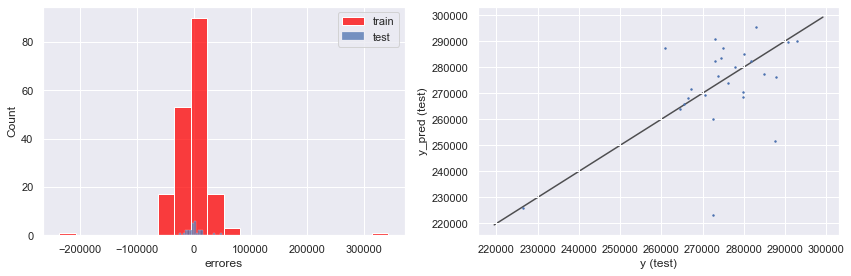

In [45]:
#Llamamos la función
evaluar_modelo('SARIMA', df_train.cantidad_peajes, df_test.cantidad_peajes, 
df_train.y_train_pred, df_test.y_test_pred)

Obtenemos un error promedio de **38378 - 15004 peajes semanales (RMSE), que representan un 6,37% - 3,48% respecto de la media (MAPE), para el test/train set, respectivamente**. El hecho de contar con un año más de datos ayudó a reducir visiblemente los errores tanto en train como en test, respecto del proyecto 3. **No hay que dejarse engañar por el hecho de tener un MAPE un tanto peor que el de la regresión lineal. Se ve claramente que el ajuste es superior**. Los errores en train y test parecen seguir una distribución normal, lo que acaba reflejándose en el gráfico de datos reales vs. predichos. A diferencia del bench, el modelo no se ve afectado por el cambio en la tendencia, y no parece haber heterocedasticidad. Vamos a pasar al Prophet.

## Prophet

Comenzamos armando el dataset específico para trabajar con Prophet. Recordemos que se trata de un modelo univariado, que requiere que la fecha se pase como timestamp con nombre 'ds', y la variable dependiente se pase como 'y'. Luego sacaremos la variable que no vamos a usar, armando una máscara, y realizaremos el train/test split, **tomando el segundo semestre del 2019 como Test**. Es importante aclarar que el **Prophet trae estacionalidad semanal por defecto, pero al trabajar con resampleo de misma longitud, esta no sirve para modelar datos** (datos que no están para ser modelados).

Primero realizamos un Prophet con hiperparámetros por defecto. Luego optimizado. Allí incorporaremos, entre otras cosas, la estacionalidad anual.

### Preparando el dataset

In [46]:
#Necesitamos 
dataset_illia_W['ds']= dataset_illia_W.index
dataset_illia_W['y']= dataset_illia_W['cantidad_peajes']

mask1= dataset_illia_W.drop(columns=['cantidad_peajes'])

#Train/test split 
threshold_date = pd.to_datetime('2019-07-01')
mask = mask1['ds'] < threshold_date

df_train = mask1[mask][['ds', 'y']]
df_test = mask1[~ mask][['ds', 'y']]

### Prophet sin optimizar

Ahora vamos a aplicar Prophet por defecto. Debajo detallamos los hiperparámetros.

In [47]:
#Importamos el Prophet
from fbprophet import Prophet

#Instanciamos el modelo por defecto y hacemos el fit; 
#recordemos que estamos trabajando sólo con estacionalidad anual
Prophet_PD = Prophet()
Prophet_PD = Prophet_PD.fit(df_train)

def predict_model(m, dataframe):
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast
    
y_pred_tr = predict_model(Prophet_PD, df_train)
y_pred_tst = predict_model(Prophet_PD, df_test)

pred=pd.concat([y_pred_tr, y_pred_tst])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


No pudimos hallar un método de prophet que nos liste el **valor por defecto de los hiperparámetros**, de modo que los escribimos aquí:
- 'growth': “linear” (como proyecta el crecimiento. La alternativa es por crecimiento logístico)
- changepoint prior scale: 0.05 (cuán flexible es la serie a cambios de tendencia, incrementando la cantidad de changepoints)
- changepoint range: 0.8 (modelo changepoints hasta en el 80% de la serie. Mayor valor incrementa probabilidad de overfitting)
- seasonality prior scale: 10 (el nivel de flexibilidad de las estacionalidades)
- seasonality_mode: additive (suma los componentes, en lugar de multiplicarlos)
- yearly_seasonality: False (no asume estacionalidad anual)
- weekly_seasonality: series de fourier de orden 3 (modela estacionalidad semanal por defecto, con series de fourier de orden 3)

Hay otros hiperparámetros, como introducir manualmente las fechas de festividades, vacaciones, u otras anómalias, recurso que no utilizaremos. 

**Graficamos**

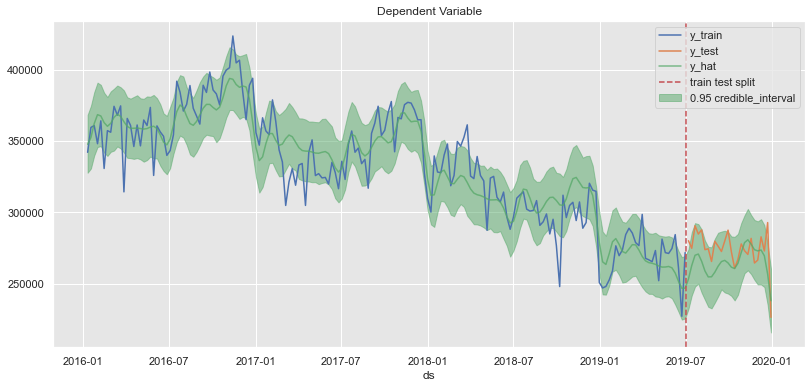

In [48]:
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

#Graficamos
threshold_date = pd.to_datetime('2019-07-01')
mask = mask1['ds'] < threshold_date

df_train_1 = mask1[mask][['ds', 'y']]
df_test_1 = mask1[~ mask][['ds', 'y']]

mask2 = pred['ds'] < threshold_date

forecast_train = pred[mask2]
forecast_test = pred[~ mask2]

fig, ax = plt.subplots(figsize=(12,6))
ax.fill_between(
    x=pred['ds'],
    y1=pred['yhat_lower'],
    y2=pred['yhat_upper'],
    color=sns_c[2], 
    alpha=0.50,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train_1, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test_1, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', color=sns_c[2], alpha=0.75, data=pred, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper right')
ax.set(title='Dependent Variable', ylabel='');

### Evaluación del modelo

El modelo a evaluar:  Prophet por defecto
Raíz del error cuadrático medio en Train: 16530.36213868234
Raíz del error cuadrático medio en Test: 15360.765118391928
Porcentaje del Error Absoluto medio en Train: 4.003058507465717
Porcentaje del Error Absoluto medio en Test: 4.665495654426356



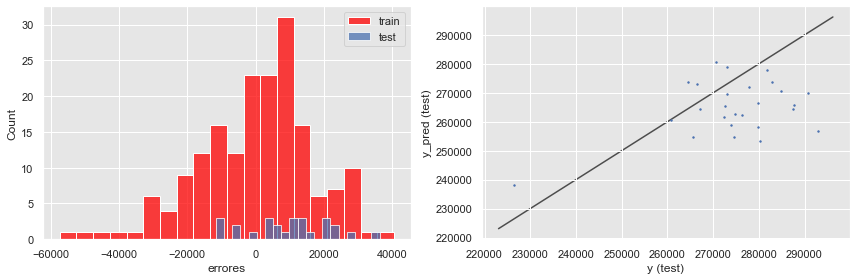

In [49]:
evaluar_modelo('Prophet por defecto', y_pred_tr['fact'], y_pred_tst['fact'], 
               y_pred_tr['yhat'], y_pred_tst['yhat'])

Obtenemos un desempeño que, medido por ambas métricas, resulta peor que el de SARIMA (set test), pero que mejoró sustancialmente contra mismo modelo de proyecto 3, con los nuevos datasets de train/test. En cuanto al análisis de errores, los del test tienen cola a la derecha.

**Vamos a probar con hiperparámetros optimizados. Recordatorio: no vamos a usar la posibilidad de la estacionalidad compleja, que Prophet posee. Eso queda para el apartado 9**.

### Prophet con optimización de Hiperparámetros 

In [50]:
import itertools
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation

m_sin_opt=Prophet()
m_sin_opt=m_sin_opt.fit(df_train)

def cv_results_model(m):
    cv_results = cross_validation (m, horizon = '90 days')
    return cv_results
    
cv_results = cv_results_model(m_sin_opt)

param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.08, 0.1, 0.2, 0.5],
    'seasonality_prior_scale': [2.0, 5.0, 10.0, 15.0],
    'changepoint_range': [0.7, 0.8, 0.9],
    'seasonality_mode':('multiplicative','additive'),
    'n_changepoints': [25, 30, 35],
    'yearly_seasonality': [True, False]
}
              
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  

for params in all_params:
    m = Prophet(**params).fit(df_train_1) 
    df_p = performance_metrics(cv_results, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 19 forecasts with cutoffs between 2017-01-11 00:00:00 and 2019-04-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

     changepoint_prior_scale  seasonality_prior_scale  changepoint_range  \
0                       0.01                      2.0                0.7   
1                       0.01                      2.0                0.7   
2                       0.01                      2.0                0.7   
3                       0.01                      2.0                0.7   
4                       0.01                      2.0                0.7   
..                       ...                      ...                ...   
859                     0.50                     15.0                0.9   
860                     0.50                     15.0                0.9   
861                     0.50                     15.0                0.9   
862                     0.50                     15.0                0.9   
863                     0.50                     15.0                0.9   

    seasonality_mode  n_changepoints  yearly_seasonality         rmse  
0     multiplic

In [51]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 2.0, 'changepoint_range': 0.7, 'seasonality_mode': 'multiplicative', 'n_changepoints': 25, 'yearly_seasonality': True}


**Vamos a usar los hiperparámetros ya optimizados para comparar con el modelo Prophet original**.

In [52]:
#Instanciamos con hiperparámetros optimizados
m1 = Prophet(changepoint_prior_scale= 0.01, 
            seasonality_prior_scale= 2.0,
            changepoint_range= 0.7,
            seasonality_mode= 'multiplicative',
            n_changepoints= 25,
             yearly_seasonality= True
                )

#Fitteamos
m1 = m1.fit(df_train_1)

y_pred_tr1 = predict_model(m1, df_train_1)
y_pred_tst1 = predict_model(m1, df_test_1)

pred=pd.concat([y_pred_tr1, y_pred_tst1])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


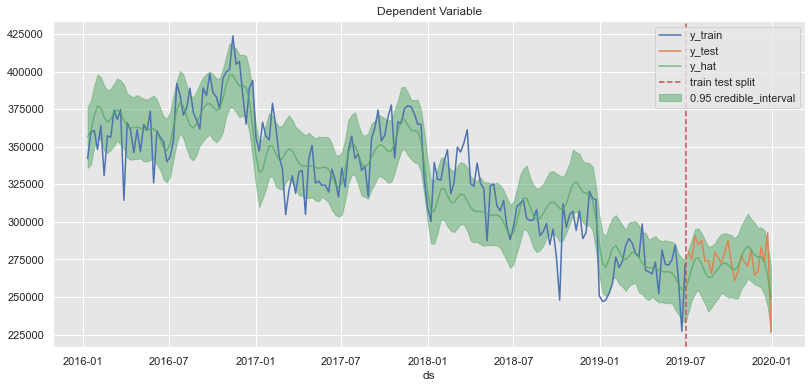

In [53]:
#Graficamos
threshold_date = pd.to_datetime('2019-07-01')
mask = mask1['ds'] < threshold_date

df_train_1 = mask1[mask][['ds', 'y']]
df_test_1 = mask1[~ mask][['ds', 'y']]

mask2 = pred['ds'] < threshold_date

forecast_train = pred[mask2]
forecast_test = pred[~ mask2]

fig, ax = plt.subplots(figsize=(12,6))
ax.fill_between(
    x=pred['ds'],
    y1=pred['yhat_lower'],
    y2=pred['yhat_upper'],
    color=sns_c[2], 
    alpha=0.50,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train_1, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test_1, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', color=sns_c[2], alpha=0.75, data=pred, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper right')
ax.set(title='Dependent Variable', ylabel='');

### Evaluación del Prophet optimizado

Vamos a evaluar el Prophet optimizado

El modelo a evaluar:  Prophet optimizado
Raíz del error cuadrático medio en Train: 17365.976033231636
Raíz del error cuadrático medio en Test: 12009.460964712243
Porcentaje del Error Absoluto medio en Train: 4.170363790741358
Porcentaje del Error Absoluto medio en Test: 3.5414829222009274



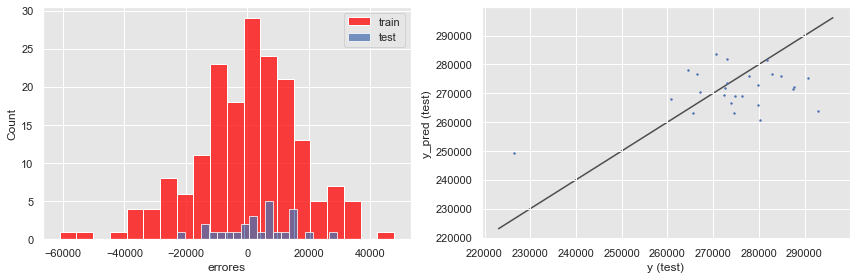

In [54]:
#Llamamos la función
evaluar_modelo('Prophet optimizado', y_pred_tr1['fact'], y_pred_tst1['fact'],
               y_pred_tr1['yhat'], y_pred_tst1['yhat'])

La **optimización da una mejora de performance importante**, en línea con el SARIMA. En general, **contar con más datos contribuyó a crear mejores modelos**. Con ambos modelos, mejoramos poco más de 10 puntos al desempeño del proyecto anterior, con resampleo semanal. 

**Ahora vamos a pasar a analizar modelos multivariados**.

# **Modelos Multivariados**: - ¿Qué efecto tiene el costo del combustible(*) en la cantidad demandada de peajes? 

*controlado por índice de salarios

- Modelo SARIMA con variable exógena (EXOG)
- Modelo RANDOM FOREST

Hemos trabajado con modelos univariados. Eso nos lleva a considerar al tiempo como el responsable de los cambios en la variable dependiente. Más bien, a considerar que hay **ciertos efectos que tienden a mitigarse o intensificarse con el paso del tiempo**. Por ejemplo, el incremento de la temperatura media durante los últimos 50 años no es un fenómeno atribuible al tiempo, pero este lo hace evidente. Tampoco las poblaciones crecen por el simple paso del tiempo. Crecen porque hay condiciones que lo favorecen (o desalientan). Basta con mirar el bono demográfico en Argentina, o el envejecimiento poblacional en la Europa desarrollada. En nuestro caso, por ejemplo, la reducción en la cantidad de peajes abonados en efectivo puede deberse a los cambios en los precios de los peajes, de las lluvias, o del valor de combustible, por citar algunos. A pesar de lo anterior, las series de tiempo con modelos univariados pueden llevarnos a estimar, con cierta precisión, como será ese futuro, si todo lo demás continúa comportandose como hasta ahora.

Ahora bien, ¿cuánto puede mejorar nuestro pronóstico al incorporar variables exógenas? Como mencionamos al principio del proyecto, estos análisis caen un tanto al vacío desde el momento en que el pago en efectivo ya no es un medio de pago vigente desde este año, y antes de eso, porque existía un profundo trade-off con el Telepase, el cuál se robustece desde el incremento de peajes en marzo 2018. Pero aún así, nos sírven para introducirnos al uso de la herramienta y ganar cierta expertise.

Hablemos de variable exógena. Queremos ver que impacto tiene la variación del costo de la nafta super de YPF en CABA en términos de salario (variación % del precio sobre variación % salarios), en el flujo vehicular en Illia con pago en efectivo. ¿Por qué elegimos la relación var%nafta/var%salarios? Si los salarios crecen a la misma tasa que el precio del combustible, este sigue ocupando una porción constante del ingreso, y salvo efecto sustitución (extraño o leve en un bien necesario), aumentos del precio tendrían efecto neutral en la demanda de uso de autopistas, aún cuando su precio se triplicara en el intervalo de tiempo analizado. Por tanto, no es el precio del combustible lo que importa, sino su peso en el ingreso. 

Para ser honestos, presumimos que la tarifa de peajes hubiese sido una variable exógena de mayor potencia explicativa, pero no pudimos (al día de hoy), dar con datos de calidad, luego de consultas a AUSA, a GBCA, y en redes. 

Vamos a pasar al análisis. Probaremos un SARIMA (exog), y un Random Forest.

## Acondicionando el nuevo dataset



Descargamos el dataset del precio de combustribles de aquí:
https://datos.gob.ar/dataset/energia-precios-surtidor---resolucion-3142016/archivo/energia_f8dda0d5-2a9f-4d34-b79b-4e63de3995df

La variación de salarios de aquí:
https://www.indec.gob.ar/ftp/cuadros/sociedad/variaciones_salarios_10_20.xls

El archivo conjunto (procesado) lo dejamos en el github. AHora vamos a acondicionar el dataset interno y el externo para poder hacer el merge. Para precios de combustibles había datos desde 2017, por lo que trabajaremos desde esa fecha.

In [55]:
#Traemos el dataset original, y filtramos para 2017/19, estación Illia y pafo efectivo 
data_MMV= dataset[(dataset['periodo']!='2016') & (dataset['estacion']=='Illia') & (dataset['forma_pago']=='EFECTIVO')]

#Resampleamos a diario
data_MMV = data_MMV.resample('D', on='fecha').sum()

#Tenemos que volver a quitar outliers. Llamamos la función creada
res, detected_outliers = hampel_filter_forloop(data_MMV.cantidad_pasos, 10)

#creamos nueva variable con los peajes tratados por outliers
data_MMV['cantidad_peajes'] = res

#Cargamos el archivo externo y lo convertimos a dataframe
data_MMV2 = pd.read_excel (r'dataYPF_y_SALARIOS_CABA_2017_2019.xlsx')

#Necesitamos igualar una columna para el merge. Vamos a renombrar 'inicio_vig'
data_MMV2.rename(columns={'inicio_vig':'fecha'}, 
                 inplace=True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data_MMV2['fecha2'] = pd.to_datetime(data_MMV2.fecha)

#Quitamos la columna fecha
data_MMV2.drop(columns=['fecha'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
data_MMV2.rename(columns = {'fecha2':'fecha'}, inplace = True)

#Pasamos fecha a index
data_MMV2.index= data_MMV2.fecha

#Debemos quitar la columna llamada como el index
data_MMV2.drop(columns=['fecha'], inplace=True)

#Ya podemos hacer el merge con el index compartido
dataset_MMV= pd.merge(data_MMV, data_MMV2, on='fecha')

#Dropeamos columnas
dataset_MMV.drop(columns=['periodo', 'hora_inicio', 'hora_fin', 'cantidad_pasos', 'mes',
       'Qk_peajes', 'precio', 'var_precio', 'porc_var_p', 'ind_salario',
       'var_salario', 'porc_var_s'], inplace=True)

##Resampleamos a semanal con suma de peajes y máximo de la relación precio/salario
dataset_MMV= dataset_MMV.resample('W').agg({'cantidad_peajes': np.sum, 'relac_precio_salario': np.max})

C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


## SARIMA con exog

El SARIMA puede utilizarse como modelo multivariado. Vamos a instanciar un modelo como en el punto 7.3.1. pero con la variable exógena.

### El modelo

C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

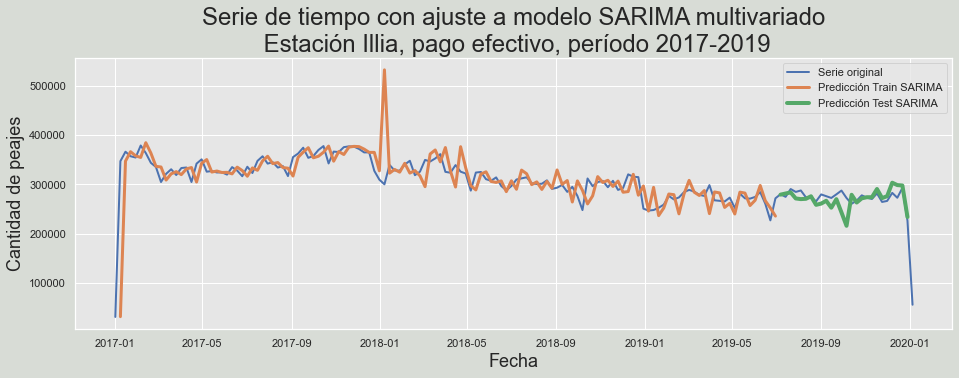

In [56]:
#Separamos el dataset en train y test
df_train = dataset_MMV.loc['2017-01-08':'2019-06-30']
df_test = dataset_MMV.loc['2019-07-01':'2019-12-29']

#Instanciamos el modelo con los hiperparámetros del punto 5, y hacemos fit.
sarima2= sm.tsa.statespace.SARIMAX(endog= df_train['cantidad_peajes'],
                                   exog= df_train['relac_precio_salario'],
                                   order=(0,1,0), 
                                   seasonal_order=(2,1,6,52),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False,
                                   freq='W', njobs=-1).fit(dis=-1)

#Debemos pasarle los valores de exog para el forecast
exog_forecast = df_test['relac_precio_salario']

#Creamos variables para los valores predichos
y_train_pred = sarima2.predict('2017-01-08','2019-06-30')
y_test_pred = sarima2.predict('2019-07-07','2019-12-29', exog=exog_forecast)
df_train ['y_train_pred'] = y_train_pred
df_test ['y_test_pred'] = y_test_pred

#Vamos a graficar la serie original y los valores predichos por el modelo
plt.figure(figsize = (14,5), facecolor='#d8dcd6')
plt.plot(dataset_MMV.index, dataset_MMV.cantidad_peajes, lw = 2, label = 'Serie original')
plt.plot(df_train.index, df_train.y_train_pred, lw = 3, label = 'Predicción Train SARIMA')
plt.plot(df_test.index, df_test.y_test_pred, lw = 4, label = 'Predicción Test SARIMA')
plt.title('Serie de tiempo con ajuste a modelo SARIMA multivariado\n Estación Illia, pago efectivo, período 2017-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
plt.legend()
plt.show()

### Evaluación del modelo

El modelo a evaluar:  SARIMA MULTIVARIADO
Raíz del error cuadrático medio en Train: 39927.95216472354
Raíz del error cuadrático medio en Test: 18081.252137372812
Porcentaje del Error Absoluto medio en Train: 6.215010073073946
Porcentaje del Error Absoluto medio en Test: 4.647455145274009



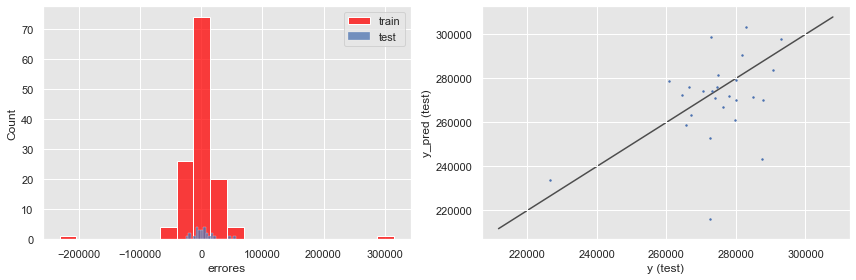

In [57]:
#Llamammos la función
evaluar_modelo('SARIMA MULTIVARIADO', df_train.cantidad_peajes, df_test.cantidad_peajes, 
               df_train.y_train_pred, df_test.y_test_pred)

**Porcentaje del Error Absoluto medio en Test: 4.64**

El MAPE es levemente superior al del SARIMA univariado. La distribución de errores es normal para train/test. Vemos un muy buen ajuste, en el gráfico predichos Vs. reales. La variable exógena no está ayudando a dar con un mejor pronóstico.

Desde luego, el inconveniente que tiene el modelo (este, como otros multivariados), para realizar el forecast, es que necesita los valores para la variable exógena. **Es una buena alternativa si deseamos construir escenarios**.

## Random Forest

El Random Forest es un modelo de ensamble de árboles, el cuál aplicamos con éxito en proyecto 2 para problemas de regresión, y que puede ser adaptado para el uso en forecast con series de tiempo, aunque quizás, no sea el modelo más adecuado para el caso específico que estamos trabajando. De todos modos, vamos a implementarlo, realizando transformaciones y aclaraciones necesarias. 

En primer lugar, y por no ser un modelo específico para series de tiempo, no podemos pasarle la fecha. Esto podríamos resolverlo, pasando la fecha como número, pero genera otros problemas. El pilar del RF está en mostrar árboles lo más diferentes posibles. ¿Cómo alimentamos esa diversidad cuando debemos trabajar con una variable que es secuencial? Es decir, cáda vez que una fecha determinada caiga en la muestra con reposición, ésta siempre tendrá asociados los mismos valores de las otras variables. Con la cuál, tenemos que quitar la variable tiempo. Segundo, hay artículos que sugieren escalado, pero esto no es necesario en modelos basados en árboles. Tercero, aparte de la variable que construimos para precios/salarios, necesitamos crear lags de Yt. En lo posible, hay que incluir los lags que contengan información importante. Quizás, lo mejor sea pasar a resampleo diario, e incluir lags para los primeros siete días (captar estacionalidad semanal), y para un año (captar estacionalidad anual). En cuanto a la variable de salida, la usaremos diferenciada, para quitar tendencia, cuyo efecto altera la predicción del Random Forest (si hay tendencia, el test tendrá necesariamente valores diferentes a los que se usaron para entrenar el modelo). Para evaluar, deberemos reescribir la forma de cálculo del MAPE, debido a errores en el cálculo de valores cercanos a cero. Para finalizar, usaremos train/test split con walk-forward validation. 

Adicionalmente, haremos una matriz de correlaciones (para ver la potencia explicativa de las variables). Vamos a realizar directamente un Grid Search para la optimización de hiperparámetros, ya que la cantidad de datos no representa una gran carga de procesamiento. Para finalizar, también realizaremos un feature_importance.

### Preparando el dataset

In [58]:
#Necesito preparar el dataset para realizar el fit, y dejar el original para realizar el predict
data= dataset_illia_diario.copy()

#Creo la variable diferenciada
data['peajes_diff']= data['cantidad_peajes'].diff()

#Quito la primera fila
data.dropna(inplace=True)

#Dropeo columnas que no necesitamos
data.drop(columns=['periodo', 'hora_inicio', 'hora_fin', 'cantidad_pasos', 'mes',
       'Qk_peajes', 'fecha_numeros', 'date_check', 'cantidad_peajes'], inplace=True)

In [59]:
#Creo los lags sobre la variable diferenciada
data['Qt-1']= data['peajes_diff'].shift(1)
data['Qt-2']= data['peajes_diff'].shift(2)
data['Qt-3']= data['peajes_diff'].shift(3)
data['Qt-4']= data['peajes_diff'].shift(4)
data['Qt-5']= data['peajes_diff'].shift(5)
data['Qt-6']= data['peajes_diff'].shift(6)
data['Qt-7']= data['peajes_diff'].shift(7)
data['Qt-365']= data['peajes_diff'].shift(365)

#Quito las filas sin datos para alguno de los lags (quitamos año entero)
data.dropna(inplace=True)

In [60]:
#Cargamos el archivo externo y lo convertimos a dataframe
data2 = pd.read_excel (r'dataYPF_y_SALARIOS_CABA_2017_2019.xlsx')

#Necesitamos igualar una columna para el merge. Vamos a renombrar 'inicio_vig'
data2.rename(columns={'inicio_vig':'fecha'}, 
                 inplace=True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data2['fecha2'] = pd.to_datetime(data2.fecha)

#Quitamos la columna fecha
data2.drop(columns=['fecha'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
data2.rename(columns = {'fecha2':'fecha'}, inplace = True)

#Pasamos fecha a index
data2.index= data2.fecha

#Debemos quitar la columna llamada como el index
data2.drop(columns=['fecha'], inplace=True)

#Ya podemos hacer el merge con el index compartido
dataset_3= pd.merge(data, data2, on='fecha')

dataset_3['Qt']= dataset_3['peajes_diff']

#Quito la fecha del índice
dataset_3= dataset_3.reset_index()

dataset_3.drop(columns=['fecha', 'precio', 'var_precio', 'porc_var_p', 'ind_salario',
       'var_salario', 'porc_var_s', 'peajes_diff'], inplace=True)

**Matriz de correlación**

Siguiendo la agenda del Random Forest, vamos a hacer un análisis de correlaciones (Pearson)

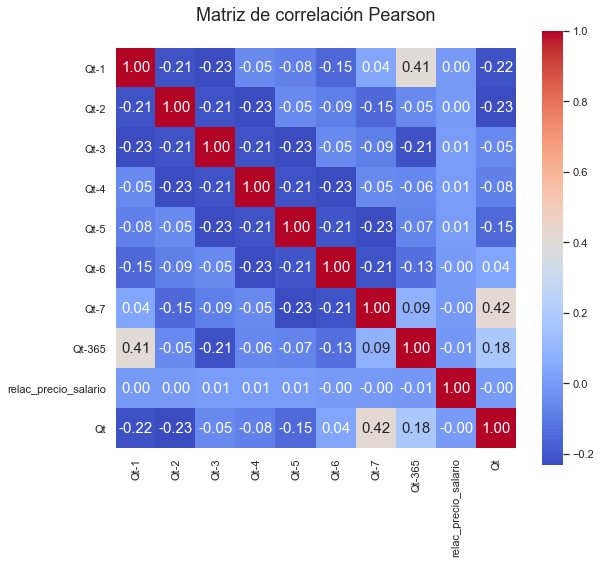

In [61]:
corr= dataset_3.corr(method='pearson')
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar=True, square=True, annot=True, fmt='.2f', annot_kws={'size':15}, cmap='coolwarm')
plt.title('Matriz de correlación Pearson\n', fontsize=18)
plt.xticks(rotation=90)
plt.show()

Es notable cómo se destacan los lags para los primeros dos días, para una semana, y para el año. Sorprende que la variable construída tenga tan poca correlación con la cantidad de peajes. Adicionalmente, las variables independientes mantienen baja correlación entre ellas (buena noticia). Vamos a armar el train/test, instanciar el modelo, hacer el Grid Search y el fit para obtener los valores de los hiperparámetros.

In [62]:
#Separamos dataset en train/test
df_train = dataset_3.iloc[:(len(dataset_3)-184)]
df_test = dataset_3.iloc[(len(dataset_3)-184):]

X_train= df_train.drop(['Qt'], axis=1)
y_train= df_train['Qt']
X_test= df_test.drop(['Qt'], axis=1)
y_test= df_test['Qt']

### El modelo

In [63]:
#Importamos las librerías
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

#instanciamos el timeseriessplit con 5 chain-foward
tscv = TimeSeriesSplit(n_splits=5)

#Instanciamos el modelo
rfr_RS = RandomForestRegressor ()

# Grilla para Random Search
param_grid = {'n_estimators': [100, 120, 150, 200, 250, 300],
               'max_depth': [10, 12, 15, 20, 25, 30, None],
               'min_samples_split': [2, 5, 10],
               'max_features': ['auto', 'sqrt'],
               'max_samples': [0.25, 0.50, 0.75]}

#Instanciamos el Grid Search, hacemos fit, e imprimimos los valores de hiperparámetros seleccionados
model_rfr_RS = GridSearchCV(rfr_RS, param_grid, scoring= 'neg_root_mean_squared_error',
                               n_jobs=-1, cv=tscv)

model_rfr_RS.fit(X_train, y_train)

print("Mejores parametros: "+str(model_rfr_RS.best_params_))
print("Mejor Score: "+str(model_rfr_RS.best_score_)+'\n')

Mejores parametros: {'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.75, 'min_samples_split': 10, 'n_estimators': 100}
Mejor Score: -5245.134879622672



**Armo el modelo con los valores surgidos del GridSearchCV, realizamos el fit y el predict**

In [64]:
#Presento el Random Forest con los hiperparámetros optimizados
rfr_opt = RandomForestRegressor (n_estimators = 100, max_depth= 10,
                                 min_samples_split= 10, max_samples= 0.75, max_features= 'sqrt')

#Fit del modelo
rfr_opt.fit(X_train, y_train)

#Predict
df_train['y_train_pred']= rfr_opt.predict(X_train)
df_test['y_test_pred']= rfr_opt.predict(X_test)

C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


**Graficamos**

C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


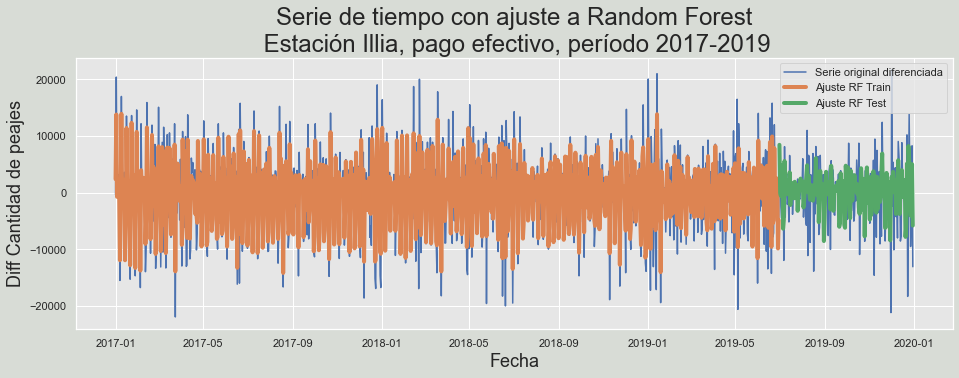

In [65]:
#Agregamos fecha para gráfico comparable
df_train['fecha']= pd.date_range(start='1/1/2017', periods=len(df_train), freq='D')
df_test['fecha']= pd.date_range(start='7/1/2019', periods=len(df_test), freq='D')
dataset_3['fecha']= pd.date_range(start='1/1/2017', periods=len(dataset_3), freq='D')

#dataset_3['fecha']= pd.date_range(start='1/1/2017', periods=len(dataset_3), freq='D')
plt.figure(figsize = (14,5), facecolor='#d8dcd6')
plt.plot(dataset_3.fecha, dataset_3.Qt, label = 'Serie original diferenciada')
plt.plot(df_train.fecha, df_train.y_train_pred, lw = 4, label = 'Ajuste RF Train')
plt.plot(df_test.fecha, df_test.y_test_pred, lw = 4, label = 'Ajuste RF Test')
plt.title('Serie de tiempo con ajuste a Random Forest\n Estación Illia, pago efectivo, período 2017-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Diff Cantidad de peajes', fontsize=18)
plt.legend()
plt.show()

### Evaluación del modelo

Necesitamos crear una función de evaluación dónde modifiquemos el cálculo del MAPE, debido a los valores cercanos a cero. Para ello, elevamos al cuadrado tanto la sumatoria como "n", y luego aplicamos raíz cuadrada al resultado para no alterar el valor. 

In [66]:
def evaluar_modelo_random(modelo, y_train, y_test, y_train_pred, y_test_pred):

    print('El modelo a evaluar: ', modelo)
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape_train = (np.sqrt(((np.abs((y_train - y_train_pred) / y_train))**2).sum()/((len(dataset_3))**2)))*100
    mape_test = (np.sqrt(((np.abs((y_test - y_test_pred) / y_test))**2).sum()/((len(dataset_3))**2)))*100

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    print(f'Porcentaje del Error Absoluto medio en Train: {mape_train}')
    print(f'Porcentaje del Error Absoluto medio en Test: {mape_test}\n')

    ### GRAFICAMOS LOS RESULTADOS
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(y_train -y_train_pred, color= 'red', bins = 20, label = 'train')
    sns.histplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test, y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
        ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

El modelo a evaluar:  Random Forest Multivariado
Raíz del error cuadrático medio en Train: 2779.823111314722
Raíz del error cuadrático medio en Test: 5085.135115119953
Porcentaje del Error Absoluto medio en Train: inf
Porcentaje del Error Absoluto medio en Test: 7.370468217765448



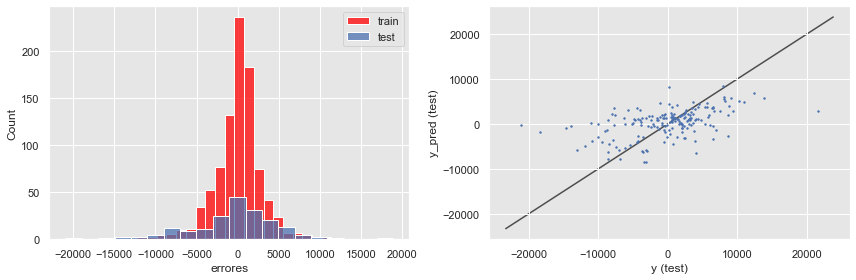

In [67]:
#Corremos la función
evaluar_modelo_random('Random Forest Multivariado', df_train['Qt'], df_test['Qt'],
                      df_train['y_train_pred'], df_test['y_test_pred'])

Este resultado si nos sorprende (en relación a pruebas efectuadas fuera del notebook). El valor del MAPE en test es realmente bueno, considerando que trabajamos con datos diarios. Los errores siguen una distribución normal. Al igual que algunos modelos, tenemos una sobrestimación para valores reales bajos, y subestimación para los altos. 

Vamos a realizar un feature importance antes de pasar a modelos de estacionalidad compleja.

Text(0, 0.5, 'Atributos modelo')

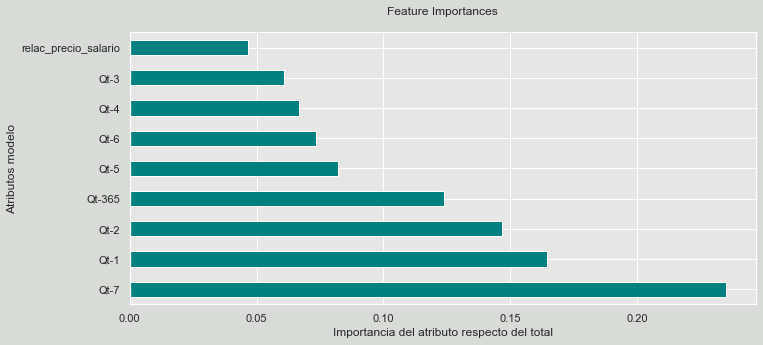

In [68]:
plt.figure(facecolor='#d8dcd6')
(pd.Series(rfr_opt.feature_importances_, index=X_train.columns)
    .nlargest(9)
    .plot(kind='barh', figsize=(10,5), title='Feature Importances\n', color='teal'))
plt.xlabel('Importancia del atributo respecto del total')
plt.ylabel('Atributos modelo')

Una de las ventajas de usar Random Forest, es que podemos conocer el peso de cada variable en la determinación de la variable dependiente. Aquí representamos ordenadamente esa importancia explicativa del peaje en t, muy en linea con lo arrojado por la matriz de correlación. El lag de semana explica poco menos de un cuarto de la variación en la cantidad de peajes, y es por lejos, la variable más importante, seguida de lags 1, 2, y 365. En conjunto, explican casi el 70% de aquella variación.

Creemos que aún pueden incorporarse varias variables al análisis (tarifa del peaje es la más importante, pero no pudimos reconstruirla con datos fehacientes), que podrían mejorar el desempeño de estos modelos.

Cerramos la parte de modelos multivariados. Vamos a pasar a estacionalidad compleja.

# **Estacionalidad compleja**: ¿Es conveniente usar modelos que sólo toleran estacionalidad simple?

En el proyecto anterior nos referimos a la dificultad que presentan series con estacionalidad múltiple, es decir, aquellas series de tiempo que tienen distintos ciclos en su comportamiento. En nuestro caso, hay evidentes patrones de estacionalidad semanal y anual (incluso diaria), que en aquél proyecto debimos sortear cambiando a resampleo semanal, para sólo trabajar con estacionalidad anual. Pero, error de novato, no lo demostramos. Entonces, ¿cómo funciona un modelo de estacionalidad simple (SARIMA, por ejemplo), con una serie temporal de frequencia diaria que muestra evidencia de estacionalidad semanal y anual? Vamos a realizar este nuevo bench, y lo compararemos contra modelos que son capaces de lidiar con aquél fenómeno. Probaremos el TBATS, y el Prophet con doble estacionalidad (yearly y weekly), modelos que no requieren de transformaciones previas.

**Modelos**:
- TBATS
- Prophet (yearly, weekly)

## El dataset

Volvemos a trabajar con resampleo diario para el pronóstico de serie temporal con estacionalidad compleja 

In [69]:
dataset_illia_diario.head(2)

periodo  hora_inicio  hora_fin  cantidad_pasos  mes  Qk_peajes  \
fecha                                                                        
2016-01-01   409248         2671      2634           25602  203     25.602   
2016-01-02   510048         2923      2936           36136  253     36.136   

            fecha_numeros  date_check  cantidad_peajes  
fecha                                                   
2016-01-01         735964         NaN            25602  
2016-01-02         735965         1.0            36136

## SARIMA con una estacionalidad (semanal)

Podríamos trabajar con la estacionalidad anual, pero el problema es que SARIMA tiene un muy elevado costo de procesamiento para estacionalidad de onda larga. Por este motivo, usaremos estacionalidad semanal. Los parámetros (p,d,q), (P,D,Q)s los elegiremos a partir del análisis de autocorrelación y autocorrelación parcial.

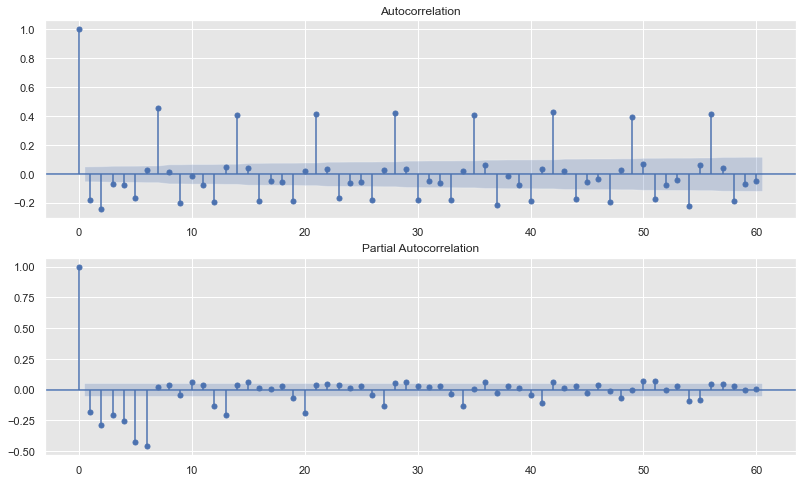

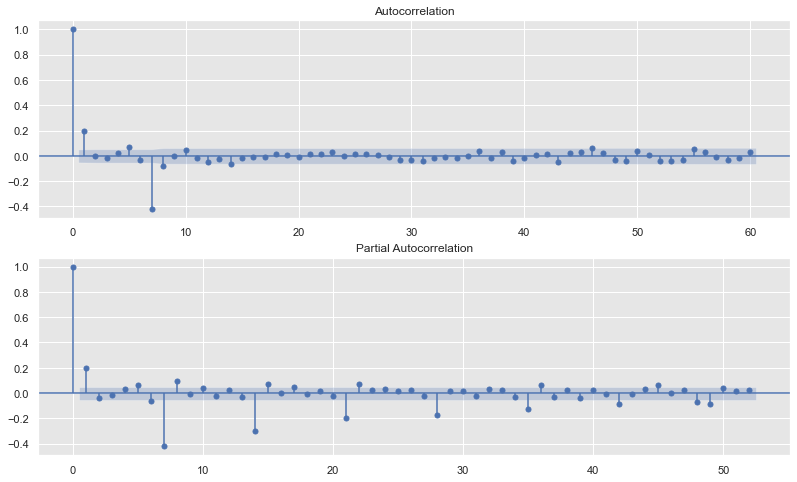

In [70]:
#Graficamos la autocorrelación y la autocorrelación parcial
fig=plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig=plot_acf(dataset_illia_diario['cantidad_peajes'].diff().dropna(), lags=60, alpha= 0.05, ax=ax1)
ax2= fig.add_subplot(212)
fig=plot_pacf(dataset_illia_diario['cantidad_peajes'].diff().dropna(), lags=60, alpha= 0.05, ax=ax2)
plt.show()

fig=plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig=plot_acf(dataset_illia_diario['cantidad_peajes'].diff(7).dropna(), lags=60, ax=ax1)
ax2= fig.add_subplot(212)
fig=plot_pacf(dataset_illia_diario['cantidad_peajes'].diff(7).dropna(), lags=52, ax=ax2)
plt.show()

Tenemos (p, d, q) = (6, 1, 5). Los componentes para la estacionalidad: (P, D, Q)m = (1, 1, 1)7.

Vamos a generar el modelo

C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

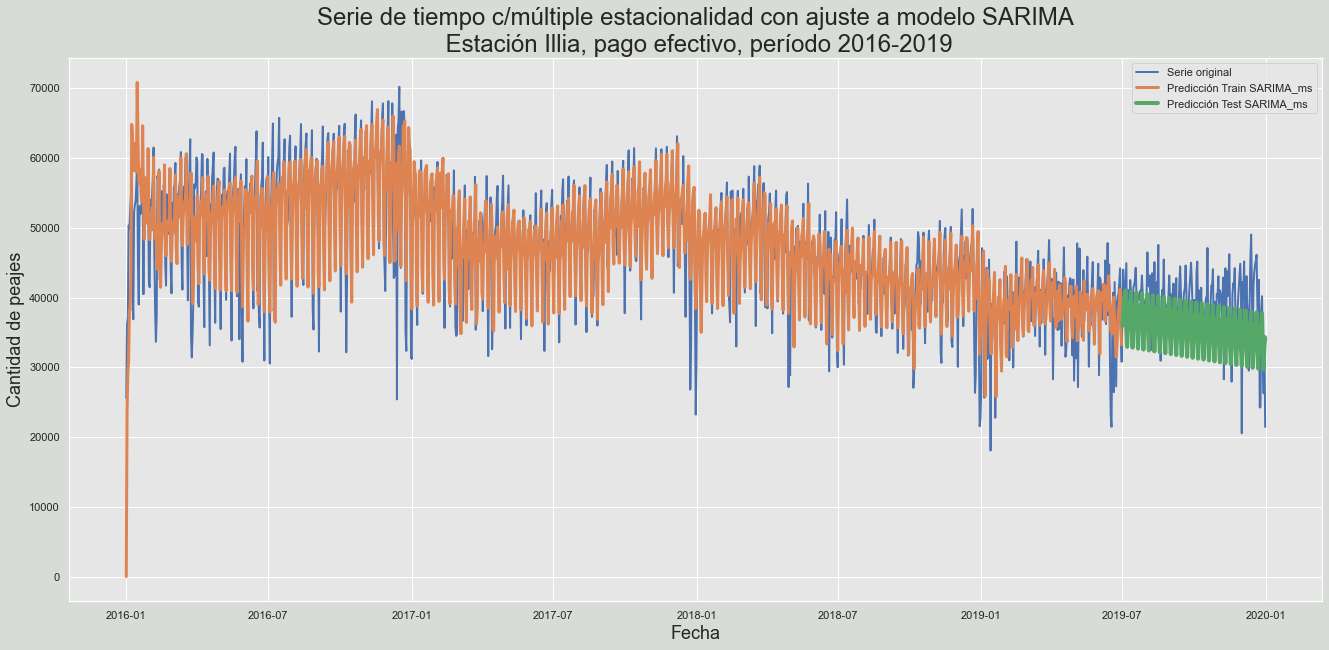

El modelo a evaluar:  SARIMA MÚLTIPLE ESTACIONALIDAD
Raíz del error cuadrático medio en Train: 5164.2908189252585
Raíz del error cuadrático medio en Test: 5556.823554965707
Porcentaje del Error Absoluto medio en Train: 8.356461934965857
Porcentaje del Error Absoluto medio en Test: 12.156837038872812



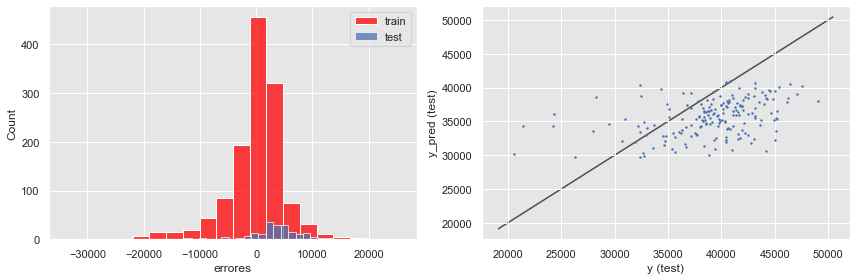

In [71]:
#separamos los datasets
df_train = dataset_illia_diario.loc['2016-01-01':'2019-06-30']
df_test = dataset_illia_diario.loc['2019-07-01':'2019-12-31']

#Instanciamos el modelo con los hiperparámetros del punto 5, y hacemos fit.
sarima_ms= sm.tsa.statespace.SARIMAX(df_train['cantidad_peajes'], order=(6,1,5), 
                                 seasonal_order=(1,1,1,7),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False, njobs=-1).fit(dis=-1)

#Hacemos el predict, y las incorporamos como variables
y_train_pred = sarima_ms.predict('2016-01-01','2019-06-30')
y_test_pred = sarima_ms.predict('2019-07-01','2019-12-31')
df_train ['y_train_pred'] = y_train_pred
df_test ['y_test_pred'] = y_test_pred

#Vamos a graficar la serie original y los valores predichos por el modelo
plt.figure(figsize = (20,10), facecolor='#d8dcd6')
plt.plot(dataset_illia_diario.index, dataset_illia_diario.cantidad_peajes, lw = 2, label = 'Serie original')
plt.plot(df_train.index, df_train.y_train_pred, lw = 3, label = 'Predicción Train SARIMA_ms')
plt.plot(df_test.index, df_test.y_test_pred, lw = 4, label = 'Predicción Test SARIMA_ms')
plt.title('Serie de tiempo c/múltiple estacionalidad con ajuste a modelo SARIMA\n Estación Illia, pago efectivo, período 2016-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
plt.legend()
plt.show()

#Llamamos la función para evaluar
evaluar_modelo('SARIMA MÚLTIPLE ESTACIONALIDAD', df_train.cantidad_peajes, df_test.cantidad_peajes, df_train.y_train_pred, df_test.y_test_pred)

En el gráfico de la serie se observa que **la predicción falla en reflejar la estacionalidad anual** (la predicción describe un trazo recto). Adicionalmente, **el MAPE es significativamente peor que el que reflejó el modelo para resampleo semanal** (12,15% contra 3,48%). 

Vamos a probar ahora la misma serie diaria, con modelos para estacionalidad compleja.

## TBATS

El modelo, como una derivación de los modelos de suavizado exponencial, está especialmente construido para lidiar con series de tiempo con estacionalidad compleja. Su nombre está formado por los acrónimos de las herramientas y métodos que utiliza (o nó) para el modelado de la serie (Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components), elementos que combina en varias alternativas, y que selecciona en su mejor versión mediante el criterio de información de Akaike (AIC), que es un método que premia la bondad del ajuste y la simplicidad del modelo. 

El modelo, únicamente univariado, tiene unos pocos hiperparámetros. Se le pasan los períodos que definen los distintos ciclos estacionales, y puede adicionalmente setearse a false la posibilidad del ajuste ARMA y el Box-Cox, cosa que no haremos.

Vamos a importar la librería, separar el dataset, instanciar el modelo, fittear, y pronosticar sobre train/test.

### Preparando el dataset

In [72]:
#Importamos la librería
from tbats import TBATS

#Seleccionamos la variable dependiente y separamos en train/test
train = dataset_illia_diario.iloc[:(len(dataset_illia_diario)-184)]
test = dataset_illia_diario.iloc[(len(dataset_illia_diario)-184):]

### El modelo

In [73]:
#Creamos el estimador y fitteamos el modelo
estimator = TBATS(seasonal_periods=(7, 365.25))
TBATS_model = estimator.fit(train['cantidad_peajes'])


#Hacemos el pronóstico para train/test
train['y_train_pred'] = TBATS_model.y_hat # in sample prediction
test['y_test_pred'] = TBATS_model.forecast(steps=184)

# Summarize fitted model
print(TBATS_model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7.   365.25]
Seasonal harmonics [3 1]
ARMA errors (p, q): (2, 2)
Smoothing (Alpha): 0.058798
Seasonal Parameters (Gamma): [ 0.00087752 -0.00027133 -0.00045848  0.00010366]
AR coefficients [-0.00045848  0.00010366]
MA coefficients [0.24631299 0.02175657]
Seed vector [45687.83517308  1983.62625011  3088.07659282   553.58357075
 -5117.26453873  -713.10518912  1094.5720018    902.15806903
 -1166.21862832     0.             0.             0.
     0.        ]

AIC 30887.903463


C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Vemos que la mejor versión del modelo, por el criterio de Akaike, surge sin utilizar la transformación Box-Cox. Usa el ajuste ARMA de los errores con (p, q): (2, 2). Vamos a graficar y evaluar el modelo.

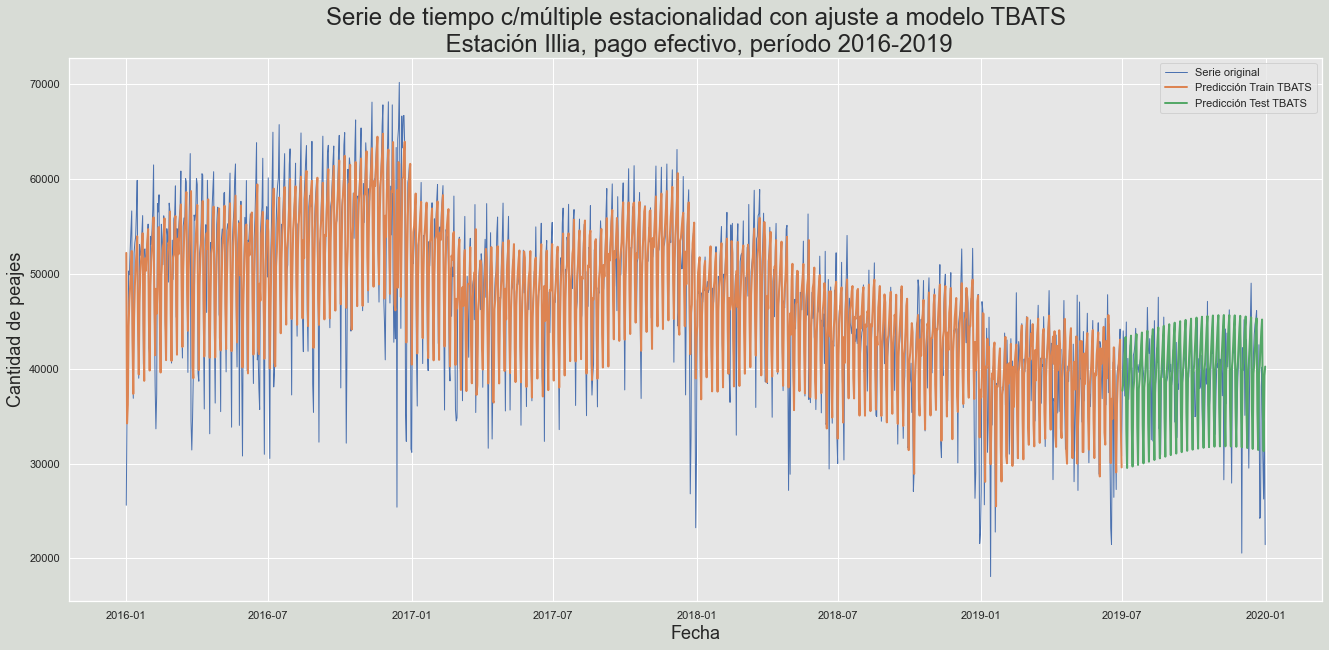

In [74]:
#Vamos a graficar la serie original y los valores predichos por el modelo
plt.figure(figsize = (20,10), facecolor='#d8dcd6')
sns.lineplot(x='fecha', y='cantidad_peajes', data=dataset_illia_diario, lw = 1, label = 'Serie original')
sns.lineplot(x='fecha', y='y_train_pred', data=train, lw = 2, label = 'Predicción Train TBATS')
sns.lineplot(x='fecha', y='y_test_pred', data=test, lw = 2, label = 'Predicción Test TBATS')
plt.title('Serie de tiempo c/múltiple estacionalidad con ajuste a modelo TBATS\n Estación Illia, pago efectivo, período 2016-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
plt.legend()
plt.show()

### Evaluación del modelo

El modelo a evaluar:  TBATS
Raíz del error cuadrático medio en Train: 4917.571737516346
Raíz del error cuadrático medio en Test: 5346.712692668814
Porcentaje del Error Absoluto medio en Train: 7.920874354556616
Porcentaje del Error Absoluto medio en Test: 10.779949823131757



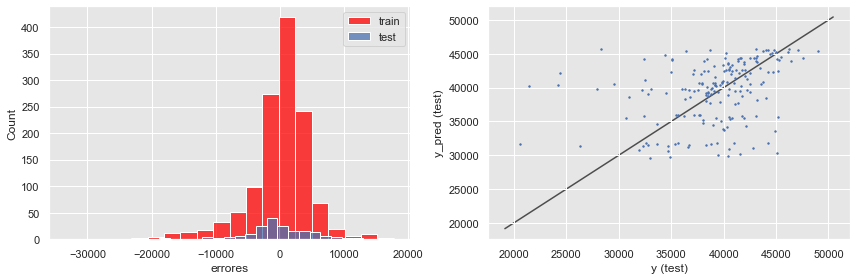

In [75]:
evaluar_modelo('TBATS', train['cantidad_peajes'], test['cantidad_peajes'], train['y_train_pred'], test['y_test_pred'])

El MAPE de test en 10,78% parece un muy buen número, considerando que trabajamos con el ruido de datos diarios. Si bien la distribución de errores es Gaussiana, predomina la sobreestimación para valores bajos, y la subestimación para los altos, lo cuál es evidente en el gráfico de las series. 

## Prophet con estacionalidad múltiple

Mencionamos anteriormente que el Prophet tiene estacionalidad semanal, aunque no nos había servido, debido al resampleo semanal. Aquí vamos a entrenar un modelo con hiperparámetros optimizados, usando la serie diaria. 

### Preparando el dataset

In [76]:
dataset_illia_diario.head(2)

periodo  hora_inicio  hora_fin  cantidad_pasos  mes  Qk_peajes  \
fecha                                                                        
2016-01-01   409248         2671      2634           25602  203     25.602   
2016-01-02   510048         2923      2936           36136  253     36.136   

            fecha_numeros  date_check  cantidad_peajes  
fecha                                                   
2016-01-01         735964         NaN            25602  
2016-01-02         735965         1.0            36136

In [77]:
#Necesitamos armar el dataset univariado
dataset_illia_diario['ds']= dataset_illia_diario.index
dataset_illia_diario['y']= dataset_illia_diario['cantidad_peajes']

mask1= dataset_illia_diario.drop(columns=['periodo', 'hora_inicio', 'hora_fin', 'cantidad_pasos',
                                          'mes', 'Qk_peajes', 'fecha_numeros', 'date_check', 'cantidad_peajes'])

#Train/test split 
threshold_date = pd.to_datetime('2019-07-01')
mask = mask1['ds'] < threshold_date

df_train = mask1[mask][['ds', 'y']]
df_test = mask1[~ mask][['ds', 'y']]

### El modelo

Vamos a realizar la búsqueda de hiperparámetros óptimos para el modelo

In [78]:
m_sin_op=Prophet()
m_sin_op=m_sin_op.fit(df_train)

cv_results = cv_results_model(m_sin_op)

param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.08, 0.1, 0.2, 0.5],
    'seasonality_prior_scale': [2.0, 5.0, 10.0, 15.0],
    'changepoint_range': [0.7, 0.8, 0.9],
    'seasonality_mode':('multiplicative','additive'),
    'n_changepoints': [25, 30, 35],
    'yearly_seasonality': [True, False]
}
              
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  

for params in all_params:
    m = Prophet(**params).fit(df_train) 
    df_p = performance_metrics(cv_results, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 19 forecasts with cutoffs between 2017-01-11 00:00:00 and 2019-04-01 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

     changepoint_prior_scale  seasonality_prior_scale  changepoint_range  \
0                       0.01                      2.0                0.7   
1                       0.01                      2.0                0.7   
2                       0.01                      2.0                0.7   
3                       0.01                      2.0                0.7   
4                       0.01                      2.0                0.7   
..                       ...                      ...                ...   
859                     0.50                     15.0                0.9   
860                     0.50                     15.0                0.9   
861                     0.50                     15.0                0.9   
862                     0.50                     15.0                0.9   
863                     0.50                     15.0                0.9   

    seasonality_mode  n_changepoints  yearly_seasonality        rmse  
0     multiplica

In [79]:
#Imprimimos los hiperparámetros seleccionados
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 2.0, 'changepoint_range': 0.7, 'seasonality_mode': 'multiplicative', 'n_changepoints': 25, 'yearly_seasonality': True}


Vamos a instanciar el modelo con los hiperparámetros optimizados, realizar el fit, y el predict.

In [80]:
#Instanciamos con hiperparámetros optimizados
m1 = Prophet(changepoint_prior_scale= 0.01, 
            seasonality_prior_scale= 2.0,
            changepoint_range= 0.7,
            seasonality_mode= 'multiplicative',
            n_changepoints= 25,
             yearly_seasonality= True
                )

#Fitteamos
m1 = m1.fit(df_train)

#Predecimos para el conjunto train/test
y_pred_tr1 = predict_model(m1, df_train)
y_pred_tst1 = predict_model(m1, df_test)

#Concatenamos de cara al gráfico
pred=pd.concat([y_pred_tr1, y_pred_tst1])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Vamos a graficar el desempeño del modelo, antes de evaluarlo.

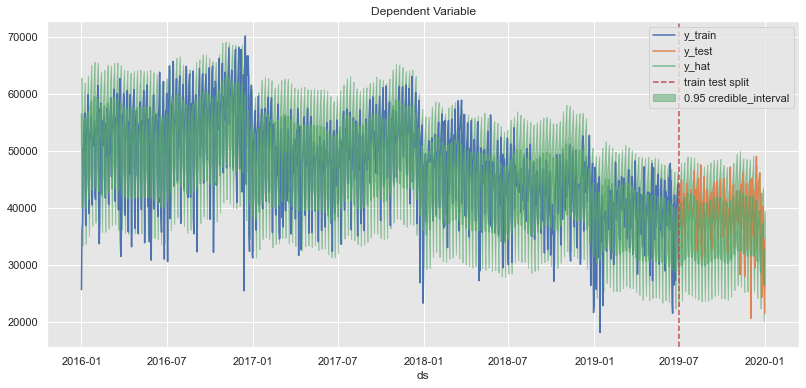

In [81]:
#Graficamos
threshold_date = pd.to_datetime('2019-07-01')
mask = mask1['ds'] < threshold_date

df_train_1 = mask1[mask][['ds', 'y']]
df_test_1 = mask1[~ mask][['ds', 'y']]

mask2 = pred['ds'] < threshold_date

forecast_train = pred[mask2]
forecast_test = pred[~ mask2]

fig, ax = plt.subplots(figsize=(12,6))
ax.fill_between(
    x=pred['ds'],
    y1=pred['yhat_lower'],
    y2=pred['yhat_upper'],
    color=sns_c[2], 
    alpha=0.50,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train_1, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test_1, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', color=sns_c[2], alpha=0.75, data=pred, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper right')
ax.set(title='Dependent Variable', ylabel='');

### Evaluación del modelo

El modelo a evaluar:  Prophet optimizado
Raíz del error cuadrático medio en Train: 4999.844664532783
Raíz del error cuadrático medio en Test: 4955.576364854892
Porcentaje del Error Absoluto medio en Train: 8.391459640849261
Porcentaje del Error Absoluto medio en Test: 10.014925281267228



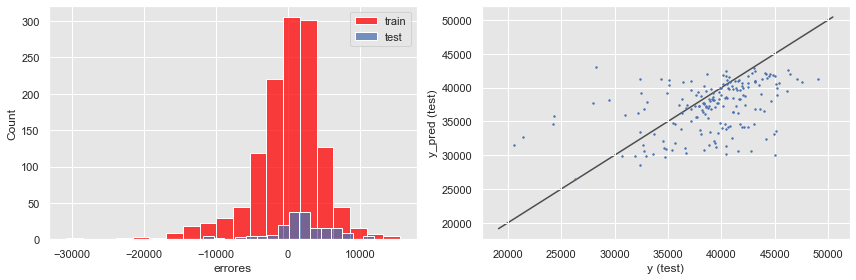

In [82]:
#Llamamos la función
evaluar_modelo('Prophet optimizado', y_pred_tr1['fact'], y_pred_tst1['fact'],
               y_pred_tr1['yhat'], y_pred_tst1['yhat'])

Porcentaje del Error Absoluto medio en Test: 10.01

El Prophet es el modelo de mejor desempeño para la serie analizada en términos de MAPE, por encima del TBATS, aunque el análisis de errores es globalmente mejor en éste (mejor distribución). El modelo de Facebook muestra ser sumamente flexible, con muy buena performance, independientemente de la cantidad y la naturaleza de los datos.

# La dificultad de trabajar con ventanas de tiempo con quiebre de tendencia: análisis final

En varios modelos hicimos notar el inconveniente de que la serie mostrara en 2019, el período para test, un comportamiento diferente al de los años precedentes, a raíz de un cambio estructural en la serie (cambio de tendencia). A modo de corolario, ya habiendo testeado distintos modelos (con el fin de demostrar su pertinencia), vamos a probar lo que consideramos es una aproximación más adecuada: trabajar con la serie para el período en que mantiene un único comportamiento.

Vamos a trabajar con datos del 2019, y con los datos pre-pandemia del 2020. Queremos, en primera instancia, verificar si hay un único comportamiento en esta nueva ventana. Si así fuese, repetiremos un análisis completo, y elegiremos un modelo que se adecúe, por cantidad de datos. Aquí debemos tener en cuenta que tanto el seasonal decompose como modelos SARIMA requieren de dos ciclos completos, por lo que no los utilizaremos. Definiremos una regresión lineal como bech, y realizaremos un Prophet, el modelo más flexible, considerando los datos disponibles.

## Preparando el dataset

In [83]:
#Cargamos el csv como dataset
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')

In [84]:
#Consultamos columnas
data_2020.head(2)

periodo                fecha    mes        dia  dia_fecha  hora_inicio  \
0     2020  2020-01-01 00:00:00  enero  Miércoles          1            0   
1     2020  2020-01-01 00:00:00  enero  Miércoles          1            0   

   hora_fin estacion tipo_vehiculo forma_pago observacion    sentido  \
0         1  ALBERDI          Auto   Efectivo    Efectivo     Centro   
1         1  ALBERDI          Auto   Efectivo    Efectivo  Provincia   

   cantidad_pasos  
0              24  
1              80

In [85]:
data_2020.columns.unique()

Index(['periodo', 'fecha', 'mes', 'dia', 'dia_fecha', 'hora_inicio',
       'hora_fin', 'estacion', 'tipo_vehiculo', 'forma_pago', 'observacion',
       'sentido', 'cantidad_pasos'],
      dtype='object')

In [86]:
#Creamos un bucle para iterar las columnas observando los valores que adoptan
lista_2=[data_2020]
variables=['periodo', 'mes', 'estacion', 'tipo_vehiculo', 'forma_pago', 'observacion',
       'sentido']
for i in lista_2:
    print('Año ', str(n))
    for j in variables:
        print(i[j].unique())      

Año  2020
[2020]
['enero' 'febrero' 'marzo' 'abril' 'mayo' 'junio' 'julio' 'agosto'
 'septiembre' 'octubre']
['ALBERDI' 'AVELLANEDA' 'DELLEPIANE LINIERSLEPIANE CENTRO'
 'DELLEPIANE LINIERS' 'ILLIA' 'ILP' 'PB1' 'PB3' 'PB4' 'RETIRO' 'SALGUERO'
 'SARMIENTO' 'PB2']
['Auto' 'Auto con trailer' 'Moto' 'N/D' 'Pago Doble Auto'
 'Pago Doble Auto con trailer / Pesado 2 Ejes' 'Pago doble Moto'
 'Pesados 2 Ejes' 'Pesados 3 Ejes' 'Pesados 4 Ejes' 'Pesados 5 Ejes'
 'Pesados 6 Ejes']
['Efectivo' 'Rec.Deuda' 'Tarjeta Magnética' 'Tag' 'Exento' 'Violación'
 'CPP']
['Efectivo' 'Paso en Infracción' 'Paso en infracción con Multa LPR'
 'T.Magnética Disc.' 'Tag - PosPago' 'Tag - PosPago OCR' 'Tag - PrePago'
 'Exento - Reglamento' 'Tag - PrePago OCR' 'Violación - Normal'
 'Exento - Otros motivos' 'Exento - Demora en cobro'
 'Violación - Via Liberada' 'Violación - Rebote' 'Violación - Repetitiva'
 'Paso a facturar - (colectivo)' 'Metrobus no hab. TAG pospago'
 'Violación - Vía Cerrada' 'Paso en Infracción con M

El nuevo dataset tiene diferencias respecto al del 2019. Cambios de denominación (ILLIA por Illia, efectivo por EFECTIVO), un mayor número de medios de pago, nuevas columnas, etc. Necesitamos acondicionarlo antes de hacer concat. 

In [87]:
data_2020P= data_2020.drop(columns=['periodo','mes', 'dia', 'dia_fecha', 'hora_inicio',
       'hora_fin', 'tipo_vehiculo', 'observacion', 'sentido'])
data_2020P.head()

fecha estacion forma_pago  cantidad_pasos
0  2020-01-01 00:00:00  ALBERDI   Efectivo              24
1  2020-01-01 00:00:00  ALBERDI   Efectivo              80
2  2020-01-01 00:00:00  ALBERDI  Rec.Deuda               1
3  2020-01-01 00:00:00  ALBERDI  Rec.Deuda               1
4  2020-01-01 00:00:00  ALBERDI  Rec.Deuda               1

In [88]:
data_2019.columns

Index(['periodo', 'fecha', 'hora_inicio', 'hora_fin', 'dia', 'estacion',
       'sentido', 'tipo_vehiculo', 'forma_pago', 'cantidad_pasos'],
      dtype='object')

In [89]:
data_2019P= data_2019.drop(columns=['periodo', 'hora_inicio', 'hora_fin', 'dia', 'sentido', 'tipo_vehiculo'])
data_2019P.head()

fecha    estacion  forma_pago  cantidad_pasos
0  2019-01-01     Alberti  NO COBRADO              22
1  2019-01-01     Alberti    TELEPASE               6
2  2019-01-01     Alberti  NO COBRADO              53
3  2019-01-01     Alberti    TELEPASE              18
4  2019-01-01  Avellaneda    EFECTIVO              16

In [90]:
#Unimos los 4 datasets. Podemos hacerlo asi directamente, ya que tienen las mismas columnas
data_prueba = pd.concat([data_2019P, data_2020P])
data_prueba.tail(2)

fecha            estacion forma_pago  cantidad_pasos
2074572  2020-10-31  DELLEPIANE LINIERS  Violación              91
2074573  2020-10-31               ILLIA  Violación              36

In [91]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data_prueba['fecha2'] = pd.to_datetime(data_prueba.fecha)

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data_prueba.drop(columns=['fecha'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
data_prueba.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reemplazamos categorias para homogeneizar el dataset
data_prueba.replace({'EFECTIVO': 'efectivo', 'ILLIA': 'Illia'}, inplace=True)
data_prueba.head(3)

estacion  forma_pago  cantidad_pasos      fecha
0  Alberti  NO COBRADO              22 2019-01-01
1  Alberti    TELEPASE               6 2019-01-01
2  Alberti  NO COBRADO              53 2019-01-01

In [92]:
#Reemplazamos categorias para homogeneizar el dataset
data_prueba.replace({'efectivo': 'Efectivo'}, inplace=True)

In [93]:
#Máscara para efectivo e Illia
mask = data_prueba[(data_prueba['estacion']=='Illia') & (data_prueba['forma_pago']=='Efectivo')]
mask.head(3)

estacion forma_pago  cantidad_pasos      fecha
80    Illia   Efectivo             537 2019-01-01
86    Illia   Efectivo               1 2019-01-01
88    Illia   Efectivo             443 2019-01-01

In [94]:
data_2019_2020= mask.resample('D', on='fecha').sum()
data_2019_2020.head(3)

cantidad_pasos
fecha                     
2019-01-01           27038
2019-01-02           47080
2019-01-03           46194

Necesitamos quitar el período dónde se inicia el ASPO (aislamiento social preventivo obligatorio). Vamos a graficar la serie 2020 para identificar el corte

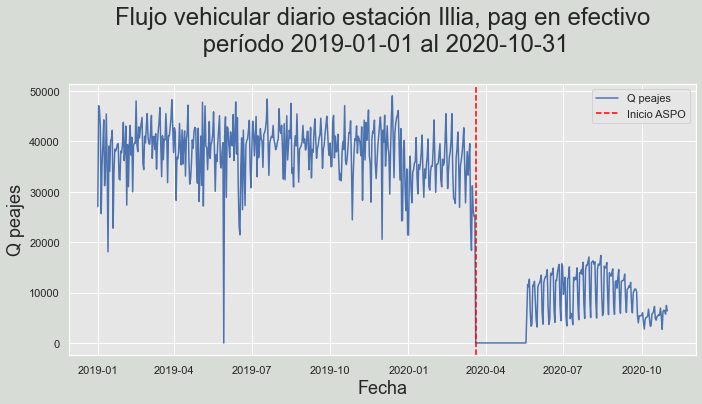

In [95]:
plt.figure(figsize = (10,5), facecolor='#d8dcd6')
ax = sns.lineplot(x= data_2019_2020.index, y='cantidad_pasos', data=data_2019_2020, palette='Paired')
plt.title('Flujo vehicular diario estación Illia, pag en efectivo\n período 2019-01-01 al 2020-10-31\n', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Q peajes', fontsize=18)
threshold_date = pd.to_datetime('2020-03-20')
plt.axvline(threshold_date, color='red', linestyle='--', label='Inicio ASPO')
plt.legend(['Q peajes', 'Inicio ASPO'])
plt.show()

Es bastante claro el corte del 20/03. Vamos a quitar además una semana extra, cubriendonos de aquellos movimientos anticipatorios a la medida de aislamiento.

In [96]:
#Separamos dataset en train/test
data_2019_2020 = data_2019_2020.loc[:'2020-03-13']
data_2019_2020.tail(2)

cantidad_pasos
fecha                     
2020-03-12           36730
2020-03-13           39548

## Preprocesar: quitar outliers

Vamos a utilizar el filtro hampel

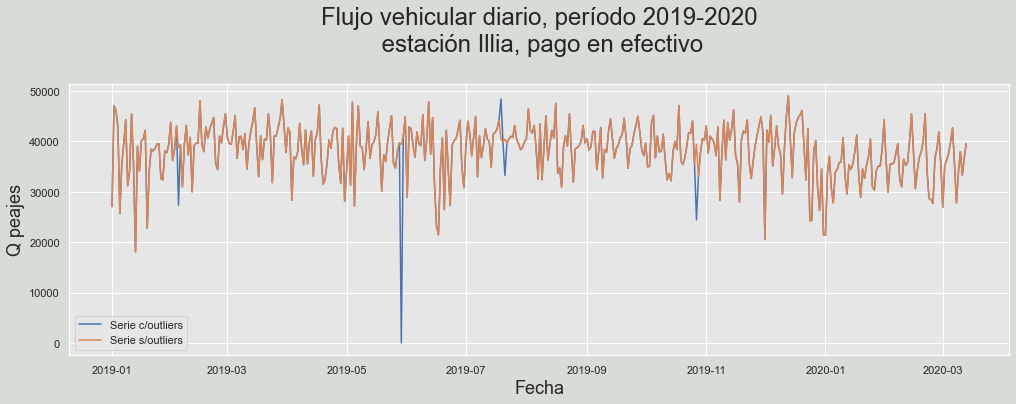

In [97]:
#Llamamos la función creada
res, detected_outliers = hampel_filter_forloop(data_2019_2020.cantidad_pasos, 10)

#creamos nueva variable con los peajes tratados por outliers
data_2019_2020['Q_peajes'] = res

#Graficamos la serie original y la preprocesada
plt.figure(figsize = (15,5), facecolor='#d8dcd6')
plt.plot(data_2019_2020.index, data_2019_2020.cantidad_pasos, label = 'Serie c/outliers')
plt.plot(data_2019_2020.index, data_2019_2020.Q_peajes, label = 'Serie s/outliers')
plt.title('Flujo vehicular diario, período 2019-2020\n estación Illia, pago en efectivo\n', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Q peajes', fontsize=18)
plt.legend()
plt.show()

data_2019_2020.drop(columns=['cantidad_pasos'], inplace=True)

El filtro corrige 5 valores. Vamos a pasar al análisis de tendencia.

## Análisis de tendencia

Gráficamente, la serie parece estacionaria. Realizaremos el ADF test y el kpss test para comprobarlo. Esperamos rechazar y aceptar la Ho, respectivamente. 

In [98]:
#AUgmented Dicki-Fuller test
adf = adfuller(data_2019_2020['Q_peajes'])
print("ADF test p-value: {}".format(float(adf[1])))

ADF test p-value: 0.00019145321873456603


In [99]:
#Kwiatkowski-Phillips-Schmidt-Shin test
from statsmodels.tsa.stattools import kpss
kpss = kpss(data_2019_2020['Q_peajes'])
print("p-value: {}".format(float(kpss[1])))

p-value: 0.02235067732617424


C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


Volvemos a tener resultados contradictorios entre los test. Vamos a ajustar la serie, a modo de prueba, a una regresión lineal.

## Ajuste de la serie a una regresión lineal

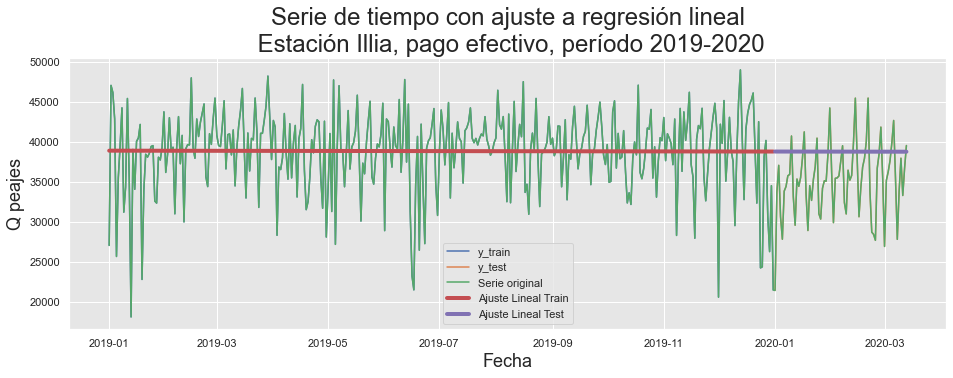

In [100]:
#Pasamos fechas a números
data_2019_2020 ['fecha_números'] = data_2019_2020.index.map(datetime.datetime.toordinal)

#Separamos dataset en train/test
df_train = data_2019_2020.loc['2019-01-01':'2019-12-31']
df_test = data_2019_2020.loc['2020-01-01':]

#Llamamos librería, instanciamos modelo, hacemos fit y predict
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr_1 = lr.fit(df_train.fecha_números.values.reshape(-1, 1), df_train.Q_peajes)
y_pred_train= lr_1.predict(df_train.fecha_números.values.reshape(-1, 1))

#Graficamos
plt.figure(figsize = (14,5))
plt.plot(df_train.index, df_train.Q_peajes, label = 'y_train')
plt.plot(df_test.index, df_test.Q_peajes, label = 'y_test')
plt.plot(data_2019_2020.Q_peajes,label='Serie original')
plt.plot(df_train.index, lr_1.predict(df_train.fecha_números.values.reshape(-1, 1)), lw = 4, label = 'Ajuste Lineal Train')
plt.plot(df_test.index, lr_1.predict(df_test.fecha_números.values.reshape(-1, 1)), lw = 4, label = 'Ajuste Lineal Test')
plt.title('Serie de tiempo con ajuste a regresión lineal\n Estación Illia, pago efectivo, período 2019-2020', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Q peajes', fontsize=18)
plt.legend()
plt.show()

Imposible no ver una serie estacionaria en 2019. En 2020 es un tanto más complicado de interpretar, a raíz de que tenemos sólo los meses de temporada estival. Vamos a evaluar el modelo.

Raíz del error cuadrático medio en Train: 5018.336682603425
Raíz del error cuadrático medio en Test: 5666.546527498778
Porcentaje del Error Absoluto medio en Train: 10.636603458104679
Porcentaje del Error Absoluto medio en Test: 14.306494326049316



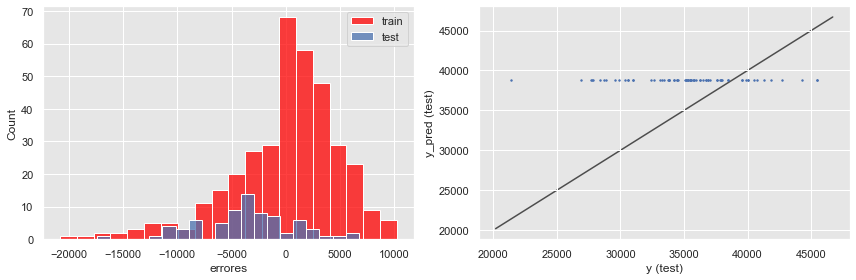

In [101]:
evaluar_regresion(lr_1, df_train['fecha_números'].values.reshape(-1, 1), df_test['fecha_números'].values.reshape(-1, 1),
df_train['Q_peajes'], df_test['Q_peajes'])

El valor de la métrica está bastante lejos de lo que esperabamos con este planteo, pero es el que se espera de un ajuste como el graficado más arriba, subestimación y sobrestimación de valores.

Vamos al modelo final. Podemos suponer una serie que se mantiene invariable en la ventana analizada. Considerando que no contamos con al menos dos años de datos como para entrenar un SARIMA, nos inclinamos por el Prophet, por su flexibilidad general.

## El modelo final: Prophet

### Preparando el dataset

In [102]:
#Preparamos datasets
data_2019_2020.drop(columns=['fecha_números'], inplace=True)
data_2019_2020['ds']= data_2019_2020.index
data_2019_2020['y']= data_2019_2020['Q_peajes']

mask1= data_2019_2020.drop(columns=['Q_peajes'])

threshold_date = pd.to_datetime('2020-01-01')
mask = mask1['ds'] < threshold_date

df_train = mask1[mask][['ds', 'y']]
df_test = mask1[~ mask][['ds', 'y']]

### El modelo

In [103]:
m_sin_o=Prophet()
m_sin_o=m_sin_o.fit(df_train)

cv_results = cv_results_model(m_sin_o)

param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.08, 0.1, 0.2, 0.5],
    'seasonality_prior_scale': [2.0, 5.0, 10.0, 15.0],
    'changepoint_range': [0.7, 0.8, 0.9],
    'seasonality_mode':('multiplicative','additive'),
    'n_changepoints': [25, 30, 35],
    'yearly_seasonality': [True, False]
}
              
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  

for params in all_params:
    m = Prophet(**params).fit(df_train) 
    df_p = performance_metrics(cv_results, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-10-02 00:00:00 and 2019-10-02 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

     changepoint_prior_scale  seasonality_prior_scale  changepoint_range  \
0                       0.01                      2.0                0.7   
1                       0.01                      2.0                0.7   
2                       0.01                      2.0                0.7   
3                       0.01                      2.0                0.7   
4                       0.01                      2.0                0.7   
..                       ...                      ...                ...   
859                     0.50                     15.0                0.9   
860                     0.50                     15.0                0.9   
861                     0.50                     15.0                0.9   
862                     0.50                     15.0                0.9   
863                     0.50                     15.0                0.9   

    seasonality_mode  n_changepoints  yearly_seasonality         rmse  
0     multiplic

In [104]:
#Imprimimos los hiperparámetros seleccionados
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 2.0, 'changepoint_range': 0.7, 'seasonality_mode': 'multiplicative', 'n_changepoints': 25, 'yearly_seasonality': True}


Instanciamos el modelo con los nuevos valores de hiperparámetros, hacemos fit y predict.

In [105]:
#Instanciamos con hiperparámetros optimizados
m_final= Prophet(changepoint_prior_scale= 0.01, 
                seasonality_prior_scale= 2.0,
                changepoint_range= 0.7,
                seasonality_mode= 'multiplicative',
                n_changepoints= 25,
                 yearly_seasonality= True
                )

#Fitteamos
m_final= m_final.fit(df_train)

#Hacemos predict
y_pred_tr_f = predict_model(m_final, df_train)
y_pred_tst_f = predict_model(m_final, df_test)

pred_F= pd.concat([y_pred_tr_f, y_pred_tst_f])

#cv_results= cv_results_model(m_final)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 432x288 with 0 Axes>

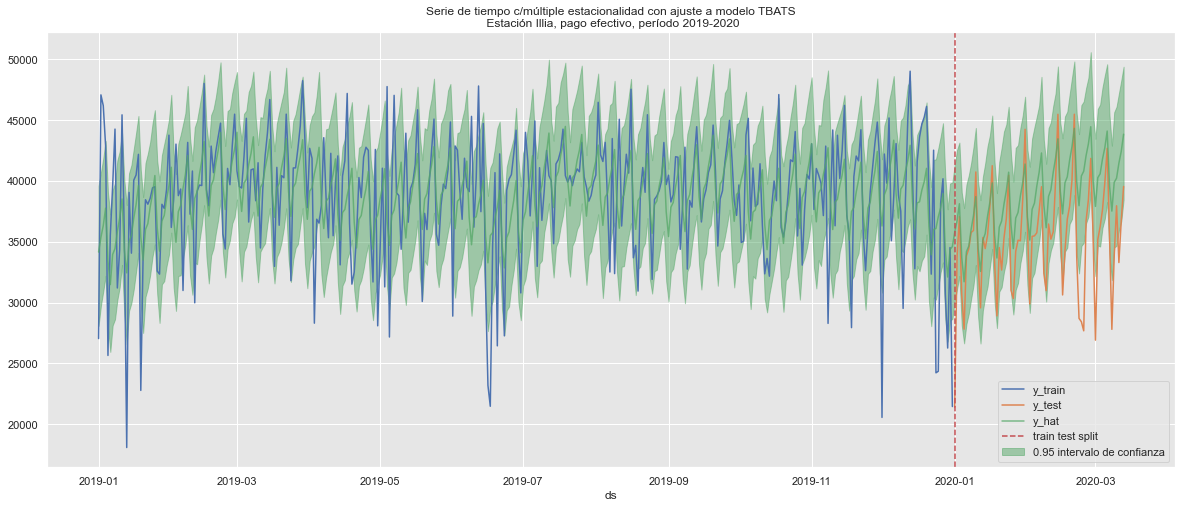

In [106]:
#Graficamos
threshold_date = pd.to_datetime('2020-01-01')
mask = mask1['ds'] < threshold_date

df_train_1 = mask1[mask][['ds', 'y']]
df_test_1 = mask1[~ mask][['ds', 'y']]

mask2 = pred['ds'] < threshold_date

forecast_train = pred[mask2]
forecast_test = pred[~ mask2]

plt.figure(facecolor='#d8dcd6')
fig, ax = plt.subplots(figsize=(18,8))
ax.fill_between(
    x=pred_F['ds'],
    y1=pred_F['yhat_lower'],
    y2=pred_F['yhat_upper'],
    color=sns_c[2], 
    alpha=0.50,
    label=r'0.95 intervalo de confianza'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', color=sns_c[2], alpha=0.75, data=pred_F, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='lower right')
ax.set(title='Serie de tiempo c/múltiple estacionalidad con ajuste a modelo TBATS\n Estación Illia, pago efectivo, período 2019-2020', ylabel='');

**El gráfico no es muy prometedor. Se observa que la predicción está siempre por encima del valor real**. Nos queda evaluar.

### Evaluación del modelo

El modelo a evaluar:  Prophet Final
Raíz del error cuadrático medio en Train: 4369.05468344017
Raíz del error cuadrático medio en Test: 4805.0010151309025
Porcentaje del Error Absoluto medio en Train: 8.980930948560793
Porcentaje del Error Absoluto medio en Test: 11.816996206561837



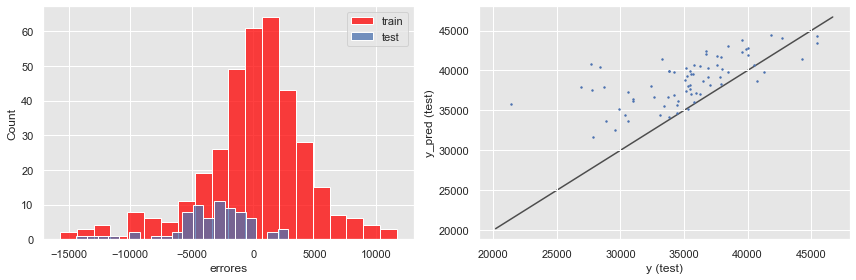

In [107]:
#Evaluamos
evaluar_modelo('Prophet Final', y_pred_tr_f['fact'], y_pred_tst_f['fact'], 
               y_pred_tr_f['yhat'], y_pred_tst_f['yhat'])

**El gráfico de la serie, de los errores, y de los valores predichos Vs. reales, nos indican lo mismo. El período 2020 (pre pandemia) es levemente distinto al precedente, lo suficiente como para que las predicciones sistemáticamente sobrestimen**. El Prophet es muy flexible para captar changepoints, pero este changepoint está en un período con el que no se entrenó el modelo. En resumen, el modelo que predijo el último semestre del 2019 tuvo mejor ingesta (sobre todo, el primer semestre de ese mismo año), que el modelo que predice el 2020. **Tal vez, es mejor elaborar el modelo Prophet asegurandose de que, al menos el período inmediato anterior al test, aún siendo pequeño, tenga el mismo comportamiento que este**.

# Conclusiones

El modelo final no mejoró, a diferencia de lo que esperabamos, aunque es claro que 2019 tiene comportamiento diferente a los años anteriores. Quizás con más datos, sin quiebre estructural, podríamos tener mejor desempeño. Adicionalmente, aún queda mucho potencial por explotar en los modelos. Queda continuar aprendiendo de las herramientas, e incluso, incorporar más y mejores variables explicativas, como en el caso de la tarifa de peajes.

Cada problema requiere del análisis de sus particularidades, y con ellas, de la selección de modelos pertinentes. Esperamos haber sido criteriosos en ese proceso.

# Fuentes de información

- Nielsen, Aileen. (2020). *Practical Time Series Analysis: Prediction with Statistics & Machine Learning*. O’Reilly Media, Inc.
- Taylor, S. J., & Letham, B. (2018). *Forecasting at scale*. The American Statistician, 72(1), 37-45. https://peerj.com/preprints/3190v2/
- Xie, T., & Ding, J. (2020). *Forecasting with Multiple Seasonality*. arXiv preprint arXiv:2008.12340.. https://arxiv.org/pdf/2008.12340.pdf
- Blaconá, M. T., & Andreozzi, L. (2013). *Modelos para series de tiempo con estacionalidad compleja*. https://www.fcecon.unr.edu.ar/web-nueva/sites/default/files/u16/Decimocuartas/blacona_andreozzi_modelos_para_series_de_tiempo.pdf
- López Sáez, José Ignacio, *Análisis de series de tiempo: pronóstico de demanda de uso de aeropuertos en Argentina al 2022*; Trabajo final integrador; ITBA. https://ri.itba.edu.ar/bitstream/handle/123456789/1230/TFI%20-%20Jose_%20Ignacio%20Lo_pez%20Sa_ez.pdf?sequence=1&isAllowed=y
- Sánchez, P. A. (2008). Cambios estructurales en series de tiempo: una revisión del estado del arte. Revista Ingenierías Universidad de Medellín, 7(12), 115-140.
https://repository.udem.edu.co/bitstream/handle/11407/958/Cambios%20estructurales%20en%20series%20de%20tiempo%20una%20revisi%C3%B3n%20del%20estado%20del%20arte.pdf?sequence=2

- https://www.machinelearningplus.com/time-series/time-series-analysis-python/
- https://otexts.com/fpp2/complexseasonality.html
- https://www.kaggle.com/wwymak/forecasting-with-prophet-not-complete-yet/data
- https://www.kaggle.com/gulyvz/time-series-forecasting-and-analysis-part-1
- https://www.kaggle.com/pbizil/random-forest-regression-for-time-series-predict
- https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7
- https://medium.com/data-science-in-your-pocket/preprocessing-for-time-series-forecasting-3a331dbfb9c2
- https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a
- https://medium.com/datadriveninvestor/why-wont-time-series-data-and-random-forests-work-very-well-together-3c9f7b271631
- https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
- https://medium.com/analytics-vidhya/time-series-analysis-using-prophet-in-python-part-2-hyperparameter-tuning-and-cross-validation-88e7d831a067
- https://medium.com/analytics-vidhya/time-series-analysis-using-prophet-in-python-part-1-math-explained-5936509c175c
- https://towardsdatascience.com/almost-everything-you-need-to-know-about-time-series-860241bdc578
- https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
- https://towardsdatascience.com/anomaly-detection-time-series-4c661f6f165f
- https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453
- https://towardsdatascience.com/how-to-forecast-sales-with-python-using-sarima-model-ba600992fa7d
- https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1
- https://towardsdatascience.com/how-to-predict-a-time-series-part-1-6d7eb182b540
- https://machinelearningmastery.com/random-forest-for-time-series-forecasting/#:~:text=Random%20Forest%20can%20also%20be,a%20supervised%20learning%20problem%20first.&text=Random%20Forest%20is%20an%20ensemble,classification%20and%20regression%20predictive%20modeling
- https://stackoverflow.com/questions/53128495/random-forest-regression-mape-divide-by-zero-error-after-minmax-scaling
- https://stats.stackexchange.com/questions/384924/using-a-random-forest-for-time-series-data

- https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html
- https://www.kdnuggets.com/2018/09/end-to-end-project-time-series-analysis-forecasting-python.html
- https://stats.stackexchange.com/questions/239360/contradictory-results-of-adf-and-kpss-unit-root-tests/239367